# Start


In [0]:
#@title Load Packages
import tensorflow as tf
tf.test.gpu_device_name()

from keras.layers import * #Input, LSTM, RepeatVector
from keras.models import Model, Sequential
from keras.layers import CuDNNLSTM
from keras import backend as K
#from recurrentshop import *


import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import math
import time

from keras.callbacks import Callback
from keras.utils import to_categorical
from IPython.display import clear_output
import keras


Using TensorFlow backend.


# f: Cyclic LR

In [0]:
#@title function: Cyclic LR
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

# f: Timesteps, PlotLoss

In [0]:
#@title functions: Timesteps, PlotLoss
# Append with timesteps
def createTimeSteps(df, lags=1):
    """
        creates the amount of timesteps from the target and appends to df.
        How many lags do we use to predict the target.
        @param df: data frame with all features
        @param lags: number of lags from the target that are appended
    """
    df = pd.DataFrame(df)
    columns = list()
    for i in range(lags, 0, -1):
        columns.append(df.shift(i))
    columns.append(df) #add original
    # combine
    output = pd.concat(columns, axis=1)
    # replace rows with NaN values
    output.fillna(0, inplace = True)
    return output
  
  
  
  # updatable plot with repeats

class PlotLosses(keras.callbacks.Callback):
    def __init__(self, repeats, BATCH_SIZE = 1000, N_NEURONS = 10, comment="", timestr = "", what = 'loss', what2 = 'val_loss'):
        self.j = 0
        self.fig = plt.figure()
        
        self.repeats = repeats
        self.batch_size = BATCH_SIZE
        self.n_neurons = N_NEURONS
        self.comment = comment
        self.timestr = timestr
        
        self.what = what
        self.what2 = what2
        
        
        self.losses = [[] for i in range(self.repeats+1)]
        self.val_losses = [[] for i in range(self.repeats+1)]
        self.logs = [[] for i in range(self.repeats+1)]
        self.x = [[] for i in range(self.repeats+1)]
        
        self.df_full = pd.DataFrame()

    def on_train_begin(self, logs={}):
        self.j += 1
        self.i = 0

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs[self.j].append(logs)
        self.x[self.j].append(self.i)
        self.losses[self.j].append(logs.get(self.what))
        self.val_losses[self.j].append(logs.get(self.what2))
        self.i += 1
        
        clear_output(wait=True)
        for self.k in range(1, self.j+1):
            plt.plot(self.x[self.k], self.losses[self.k], label=self.what, color='orange')
            plt.plot(self.x[self.k], self.val_losses[self.k], label=self.what2, color='blue')
        #plt.legend()
        self.filename = self.timestr + self.comment + "_" + self.what + "_plot.png"
        
        print(self.timestr + self.comment)
        
        plt.savefig(self.filename, bbox_inches='tight', pad_inches=0)
        plt.show()
        
        print(K.eval(self.model.optimizer.lr))
        print(self.batch_size)
        print(self.n_neurons)
        
        
    def on_train_end(self, logs={}):
        self.df = pd.DataFrame({'X': self.x[self.k], 'loss': self.losses[self.k], 'val_loss': self.val_losses[self.k]})
        self.df_full = pd.concat([self.df_full, self.df], axis=1#, sort=False
                                 
                                )
        return self.df_full
        ;


# Access Drive

In [0]:
#@title Access Drive
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1qZCA1zi0Ynhkr9VlWVUM4bsrdl2R7ZA3'}) # replace the id with id of file you want to access
downloaded.GetContentFile('bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv')  

#3. Read file as panda dataframe
#import pandas as pd
df = pd.read_csv('bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv') 

df.shape




# Upload Files (Saving)
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload






# Take the hourly mean

df['hour'] = pd.to_datetime(df['Timestamp'],unit='s').dt.floor('60 min')
group = df.groupby('hour')

# df['minute'] = pd.to_datetime(df['Timestamp'],unit='s').dt.floor('1 min')
# group = df.groupby('minute')

Real_Price = group['Weighted_Price'].mean()
Real_Price = pd.DataFrame(Real_Price)

diff = Real_Price.diff()
diff = diff.iloc[1:]
diff.columns = ['Price']

Real_Price.shape




(8528, 1)

In [0]:
#### OPTIONAL

#2. Get the file
downloaded = drive.CreateFile({'id':'1damVpEeABRpUwgcOr_LWcDQYbeW9M7bN'}) # replace the id with id of file you want to access
downloaded.GetContentFile('20180911-143040_yhat_test.csv')  

#3. Read file as panda dataframe
#import pandas as pd
yhat_test_csv = pd.read_csv('20180911-143040_yhat_test.csv',header=None) 

yhat_test_csv.shape

(7200, 2)

In [0]:
#### OPTIONAL

#2. Get the file
downloaded = drive.CreateFile({'id':'1hJFnO8f27llSHEgZquRxsujKWdFJHmFW'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded.GetContentFile('20181226-203204_yhat_test.csv')  

#3. Read file as panda dataframe
#import pandas as pd
yhat_test_csv_lstm_sl = pd.read_csv('20181226-203204_yhat_test.csv',header=None) 

yhat_test_csv_lstm_sl.shape


(7200, 2)

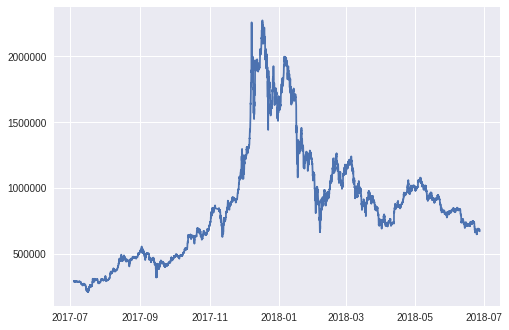

In [0]:
plt.plot(Real_Price)
plt.show()

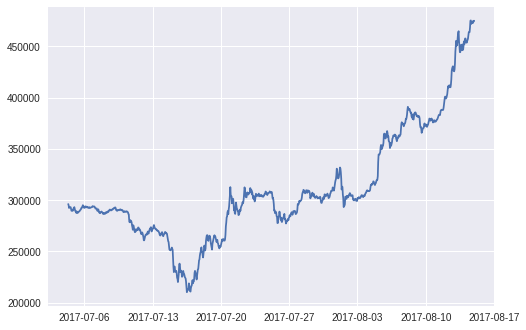

In [0]:
plt.plot(Real_Price[:1000])
plt.show()

In [0]:
Real_Price.iloc[:10]

In [0]:
plt.plot(diff.iloc[20000:])

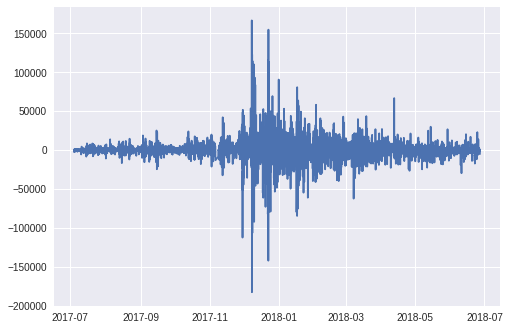

In [0]:
#plt.plot(diff)
#plt.plot(diff.iloc[:20000])
#plt.plot(diff.iloc[20000:])
plt.plot(diff)
plt.show()

In [0]:
type(diff)

In [0]:
len(diff[diff['Price'] == 0])

In [0]:
diff[diff['Price'] == 0]

# Set Timesteps, FEE, createTimeSteps

In [0]:
TIMESTEPS = 60 # length of Sequence we use for our samples (7 = week, 30 = month) LAGS = 7
FEATURES = 1
INPUT_VARS = int(TIMESTEPS*FEATURES) # Every feature has as many columns as defined timestep

# INIT_T = 30000
# TEST_T = 10000

INIT_T = 1000
TEST_T = 400


# Rescale
#MAX_ABS = float(np.abs(diff.iloc[:(INIT_T+TIMESTEPS)]).max())
#MAX_ABS = 4937
MAX_ABS = 200000


#FEE = 0.0032
#FEE = 0.005
FEE = 0.0025

TRANSACTION_SIZE = 300000/MAX_ABS
#TRANSACTION_SIZE = 300000

### Drop rows with zero change - 37 obs.
diff = diff.drop(diff[diff['Price'] == 0].index)




# TIME STEPS
full_df = createTimeSteps(diff, TIMESTEPS)
full_df = full_df[TIMESTEPS:]  #Cut the empty timesteps
full_df = full_df.values # Training vs Test


In [0]:
len(diff[diff==0])

8527

In [0]:
full_df.shape

(8467, 61)

In [0]:
MAX_ABS

200000

# Create Train/Test


In [0]:
# X_train, X_test for parameter tunning - first 15k as training(last 3k validation), next 5k as test

train = full_df[:INIT_T, :]
test = full_df[INIT_T:(INIT_T+TEST_T), :]


X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)




#import math
# Calculate MAX_ABS for the first iteration and test (simply Rescale). 
# Find the biggest value for training dataset (without validation set)

MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-200]).max()))
MAX_ABS




X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS


TRANSACTION_SIZE = 300000/MAX_ABS/20
#TRANSACTION_SIZE = 300000
TRANSACTION_SIZE



1.0828761189719898

In [0]:
#X_train[:-200].shape

In [0]:
TRANSACTION_SIZE = 0.5

TRANSACTION_SIZE = TRANSACTION_SIZE/20

In [0]:
FEE

0.0025

# Reward functions

In [0]:
# Cummulative Profit
def negative_profit(y_true, #future_price_change
                    y_pred, #action
                    FEE = FEE,
                    TRANSACTION_SIZE = TRANSACTION_SIZE): 
  
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    profit = K.sum(y_pred*y_true) - K.sum(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
    loss = -profit
    return loss
#- (K.sum(action*future_price) - FEE* K.abs(action - prev_output))



def negative_profit_avg(y_true, #future_price_change
                    y_pred, #action
                    FEE = FEE,
                    TRANSACTION_SIZE = TRANSACTION_SIZE): 
  
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
    loss = -profit
    return loss
#- (K.sum(action*future_price) - FEE* K.abs(action - prev_output))



# Cummulative Profit
def negative_profit_trading(y_true, #future_price_change
                    y_pred, #action
                    FEE = FEE,
                    TRANSACTION_SIZE = TRANSACTION_SIZE): 
  
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    profit = K.sum(y_pred*y_true) - K.sum(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
    trading_reward  = K.sum(K.square(K.abs(y_pred)))
    reward = profit + 0.0001*trading_reward                   
    loss = -reward
    return loss
#- (K.sum(action*future_price) - FEE* K.abs(action - prev_output))



# Cummulative Profit
def negative_profit_no_fees(y_true, #future_price_change
                    y_pred, #action
                    FEE = FEE,
                    TRANSACTION_SIZE = TRANSACTION_SIZE): 
  
    #lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    profit = K.sum(y_pred*y_true) #- K.sum(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
    loss = -profit
    return loss
#- (K.sum(action*future_price) - FEE* K.abs(action - prev_output))




def negative_profit_avg_no_fees(y_true, #future_price_change
                    y_pred, #action
                    #FEE = FEE,
                    #TRANSACTION_SIZE = TRANSACTION_SIZE
                               ): 
  
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    profit = K.mean(y_pred*y_true)# - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
    loss = -profit
    return loss
#- (K.sum(action*future_price) - FEE* K.abs(action - prev_output))




# Utility function based on Dempster (2006)
def negative_utility(y_true, #future_price_change
                     y_pred, #action
                     FEE = FEE,
                     TRANSACTION_SIZE = TRANSACTION_SIZE,
                     Z = 100, #for sharpening the indicator function
                     V = 0.25, #trader's personal risk aversion
                     A = 100): #constant
                     
    #use sigmoid as indicator function https://en.wikipedia.org/wiki/Heaviside_step_function#Analytic_approximations
    risk_measure = K.sum(K.square(y_pred*y_true)*K.sigmoid(-y_pred*y_true*K.constant(Z)))/(K.sum(K.square(y_pred*y_true)*K.sigmoid(y_pred*y_true*K.constant(Z))) + K.epsilon())
    
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    avg_profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(TRANSACTION_SIZE)*K.constant(FEE)
    
    utility = A*(1-V)*avg_profit - V*risk_measure
                         
    loss = -utility
    return loss

  
  
  
  # avg_profit/std_profit
def negative_sharpe_ratio(y_true, #future_price_change
                          y_pred, #action
                          FEE = FEE,
                          TRANSACTION_SIZE = TRANSACTION_SIZE): 
    
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    avg_profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(TRANSACTION_SIZE)*K.constant(FEE)
    std_profit = K.std(y_pred*y_true) + K.epsilon()
    
    sharpe_ratio = avg_profit/std_profit
    
                         
    loss = -sharpe_ratio
    return loss

# Build RL LSTM

In [0]:

def build_model_stacked(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features), stateful=True, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=True, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=True))
    model.add(Dense(1, activation='tanh'))
    #model.compile(loss=loss, optimizer='adam')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
# Not stateful

def build_model_stacked(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features), stateful=False, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=False, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=False))
    model.add(Dense(1, activation='tanh'))
    #model.compile(loss=loss, optimizer='adam')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
#Train model for TUNNING

# #LSTM CELL
# #the shape of the input to an LSTMCell would be (batch_size, input_dim)
# model = Sequential()
# model.add(CuDNNLSTM(6, batch_input_shape=(BATCH_SIZE, X_train.shape[1], X_train.shape[2]), stateful=True))
# model.add(Dense(1, activation='tanh'))

# model.compile(loss=negative_profit, optimizer='adam')



def build_model(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                       ))
    model.add(Dense(1, activation='tanh'))
    
    #model.compile(loss=loss, optimizer='adam')
    
    #model.compile(loss=loss, optimizer='RMSprop')
    
    
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    
#     RMSprop = keras.optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=None, decay=0.0)
#     model.compile(loss=loss, optimizer=RMSprop)
    
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
#Train model for TUNNING

# #LSTM CELL
# #the shape of the input to an LSTMCell would be (batch_size, input_dim)
# model = Sequential()
# model.add(CuDNNLSTM(6, batch_input_shape=(BATCH_SIZE, X_train.shape[1], X_train.shape[2]), stateful=True))
# model.add(Dense(1, activation='tanh'))

# model.compile(loss=negative_profit, optimizer='adam')



def build_model(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                       ))
    model.add(Dense(1, activation='tanh'))
    
    #model.compile(loss=loss, optimizer='adam')
    
    #model.compile(loss=loss, optimizer='RMSprop')
    
    
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
    
    RMSprop = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss=loss, optimizer=RMSprop)
    
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
from numpy.random import seed
seed()

In [0]:

### Run model one time and save weights and plots

#model.reset_states() 

#import time
timestr = time.strftime("%Y%m%d-%H%M%S")

BATCH_SIZE = 5
N_NEURONS = 60


LR = 0.0001
REPEATS = 1


#clr_triangular  = CyclicLR(mode='triangular')
#clr_triangular  = CyclicLR(mode='triangular2')
#clr_triangular._reset(new_base_lr=0.0001, new_max_lr=0.0005)

clr_triangular  = CyclicLR(base_lr=0.00001, max_lr=0.001,
                           step_size=30., mode='exp_range',
                           gamma=0.99998)


# clr_triangular  = CyclicLR(base_lr=0.0001, max_lr=0.01,
#                            step_size=50., mode='exp_range',
#                            gamma=0.99998)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=35, verbose=0, mode='min', baseline=None)

#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00000000001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)


filepath = timestr + "_" +"weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


filepath_loss = timestr + "_" +"weights.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss, monitor='loss', verbose=1, save_best_only=True, mode='min')


#plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, timestr = timestr)


for i in range(REPEATS):
  print (i+1)
 
  model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = #negative_profit_avg_no_fees, #
                      negative_profit_avg,
                      #negative_profit_trading,
                      
                      n_neurons = N_NEURONS, lr = LR)
  model.fit(X_train, y_train,
            epochs=3000,
            batch_size=BATCH_SIZE,
            shuffle=False,
            validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[checkpoint, checkpoint_loss,  plot_losses, clr_triangular, early_stop #, reduce_lr
                      ],
            verbose=1)

  model.reset_states() 
    
    

# Train model for 2nd iteration - 3times longer train, maxabs/20, trans/20

In [0]:
# INIT_T = 1000
# TEST_T = 400
INIT_T = 3000
TEST_T = 1200


t = 0

train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)


MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-600]).max()))

MAX_ABS = MAX_ABS/20

TRANSACTION_SIZE = 300000/MAX_ABS/20
#TRANSACTION_SIZE = 300000/MAX_ABS

X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS


def negative_profit_avg(y_true, #future_price_change
				y_pred, #action
				FEE = FEE,
				TRANSACTION_SIZE = TRANSACTION_SIZE): 
  lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
  profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
  loss = -profit
  return loss



20181230-150437


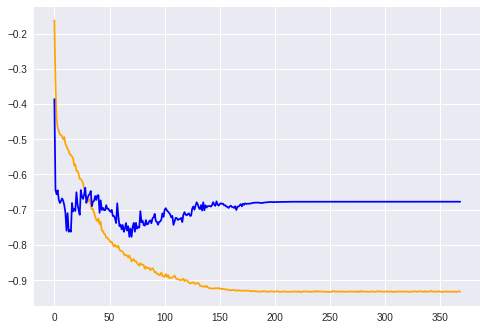

1e-11
5
60


In [0]:

### Run model one time and save weights and plots

#model.reset_states()
# keras.initializers.lecun_uniform(seed=666)
keras.initializers.glorot_uniform(seed=None)
#keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

#import time
timestr = time.strftime("%Y%m%d-%H%M%S")

BATCH_SIZE = 5
N_NEURONS = 60


LR = 0.001
REPEATS = 1


#clr_triangular  = CyclicLR(mode='triangular')
#clr_triangular  = CyclicLR(mode='triangular2')
#clr_triangular._reset(new_base_lr=0.0001, new_max_lr=0.0005)

clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.01,
                           step_size=30., mode='exp_range',
                           gamma=0.99998)


# clr_triangular  = CyclicLR(base_lr=0.0001, max_lr=0.01,
#                            step_size=50., mode='exp_range',
#                            gamma=0.99998)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00, patience=300, verbose=0, mode='min', baseline=None)

#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00000000001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)


filepath = timestr + "_" +"weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


filepath_loss = timestr + "_" +"weights.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss, monitor='loss', verbose=1, save_best_only=True, mode='min')


#plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, timestr = timestr)


for i in range(REPEATS):
  print (i+1)
 
  model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = #negative_profit_avg_no_fees, #
                      negative_profit_avg,
                      #negative_profit_trading,
                      
                      n_neurons = N_NEURONS, lr = LR)
  model.fit(X_train, y_train,
            epochs=1000,
            batch_size=BATCH_SIZE,
            shuffle=True,
            validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[checkpoint, checkpoint_loss,  plot_losses,# clr_triangular, 
                       early_stop , reduce_lr
                      ],
            verbose=0)

  model.reset_states() 
    
    

# Train model and choose the best weights / save to Drive


In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload

In [0]:
folder_id = '1-cjY2-aqUiNmSGWJdG13zzJADM5lRKIQ'

file_metadata = {
    'name': filepath,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filepath,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))

File ID: 1TBo4i6oVE93qdnlQUBrLtaOYhTBY-jQL


In [0]:
#folder_id = '1nEB7XreX92hyNiGYb5nwmjLy6PBntb1c'

file_metadata = {
    'name': filepath_loss,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filepath_loss,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))

File ID: 1CMw15wLi0K3oulkOG0X44mWrQ0CGTPle


In [0]:
#folder_id = '1nEB7XreX92hyNiGYb5nwmjLy6PBntb1c'
comment = ""
filename_plot = timestr + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))

File ID: 1Buzok9UgQGz9Z4BoaXTVHks94Xj-FE7R


# Train model with saved weights/Get weights/Test

In [0]:
import os
print( os.getcwd() )
#print( os.listdir('data') )
print( os.listdir() )

/content
['.config', 'sample_data', 'adc.json', 'bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv']


In [0]:
#Download weights (on val_loss) from Drive
#2. Get the file
downloaded = drive.CreateFile({'id':'1p59N05MbEeUTQIC95ZB7rIRvk9lzDFuD'}) # replace the id with id of file you want to access
downloaded.GetContentFile('20181228-185310_weights.best.hdf5') 

#Assign filepath
filepath = '20181228-185310_weights.best.hdf5'

In [0]:
BATCH_SIZE = 200
N_NEURONS = 60
LR = 0.0003

REPEATS = 1


n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = negative_profit_avg
features=1
timesteps = TIMESTEPS
lr = LR

model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath)
model.compile(loss=loss, optimizer=adam)

In [0]:
# from google.colab import files
# files.download('weights.best.hdf5')
# files.download('weights.best_loss.hdf5')

In [0]:
yhat_train = model.predict(X_train, batch_size = BATCH_SIZE)

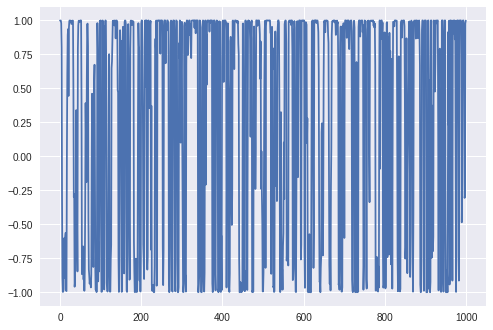

In [0]:
plt.plot(yhat_train)
plt.show()

In [0]:
X_test[:9000].shape

(400, 60, 1)

In [0]:
#yhat_test = model.predict(X_test[:9000], batch_size = BATCH_SIZE)
yhat_test = model.predict(X_test, batch_size = BATCH_SIZE)

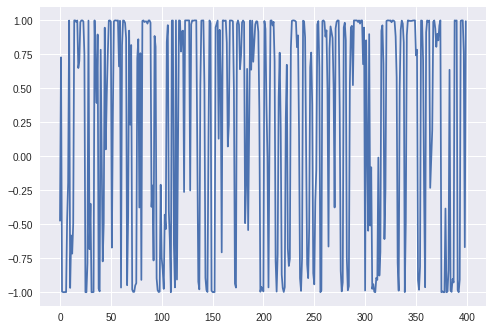

In [0]:
plt.plot(yhat_test)
plt.show()


In [0]:
model.evaluate(X_test, y_test, batch_size = BATCH_SIZE, verbose=2) 

-0.006987306987866759

In [0]:
model.evaluate(X_train[:800], y_train[:800], batch_size = BATCH_SIZE, verbose=2)  

-0.0065934627782553434

In [0]:
model.evaluate(X_train[800:], y_train[800:], batch_size = BATCH_SIZE, verbose=2) 

-0.0310938972979784

In [0]:
X_test[:9000].shape

In [0]:
model.evaluate(X_test[:9000], y_test[:9000], batch_size = BATCH_SIZE, verbose=2) 

In [0]:
model.evaluate(X_test[:3000], y_test[:3000], batch_size = BATCH_SIZE, verbose=2) 

In [0]:
model.evaluate(X_test[3000:6000], y_test[3000:6000], batch_size = BATCH_SIZE, verbose=2) 

In [0]:
model.evaluate(X_test[6000:9000], y_test[6000:9000], batch_size = BATCH_SIZE, verbose=2) 

In [0]:
model.evaluate(X_train, y_train, batch_size = BATCH_SIZE, verbose=2) 

In [0]:
#DF with all losses and val_losses from training
plot_losses.df_full

# Train FULL model with Iterations

In [0]:
filepath = "20180910-102450_weights.best.hdf5"
# filepath_loss = "20180910-102450_weights.best_loss.hdf5"

In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload

20181229-154256_iter_17_


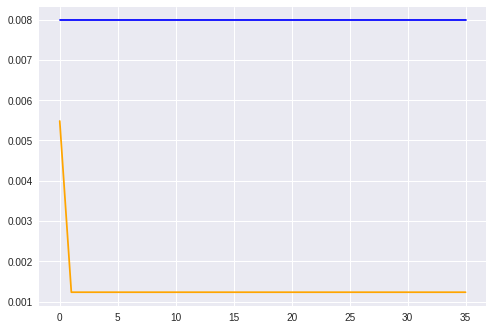

5e-05
5
60
File ID: 1nrdpdEZo6D59JmPgM7ZVCpBHTw5J0kPq
File ID: 13UHW05ZQ2_f3M5wsrJ4Rk5HfL5kiMlvX


In [0]:
BATCH_SIZE = 5
N_NEURONS = 60
LR = 0.0001


N_EPOCHS = 1000
TIMESTEPS = 60
REPEATS = 1


#TRANSACTION_SIZE = 0



# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = negative_profit_avg
features=1
timesteps = TIMESTEPS
lr = LR


#model.reset_states() 
##### BUILD MODEL with saved weights

# model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
# model.reset_states()

model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath)
model.compile(loss=loss, optimizer=adam)
######


#####  Don't train the model for the first round (use from saved weights from above)
t = 0
yhat_test = np.empty((0,2), float)


#### Rebuild the original test/train set
train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

# # Rescale
# X_train = X_train/MAX_ABS
# y_train = y_train/MAX_ABS
# X_test = X_test/MAX_ABS
# y_test = y_test/MAX_ABS


#import math
# Calculate MAX_ABS for the first iteration and test (simply Rescale). 
# Find the biggest value for training dataset (without validation set)
MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-200]).max()))
TRANSACTION_SIZE = 300000/MAX_ABS/20

X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS



####### model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test_temp = np.column_stack((y_test, pred_temp))
yhat_test = np.concatenate((yhat_test, yhat_test_temp))


t += 1


###### Loop for further iterations
while ((INIT_T + TEST_T*t + TEST_T) <= len(full_df)):

    train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
    test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

    X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
    X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

    X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
    X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

    # # Rescale
    # X_train = X_train/MAX_ABS
    # y_train = y_train/MAX_ABS
    # X_test = X_test/MAX_ABS
    # y_test = y_test/MAX_ABS


    #import math
    # Calculate MAX_ABS for the first iteration and test (simply Rescale). 
    # Find the biggest value for training dataset (without validation set)
    MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-200]).max()))
    TRANSACTION_SIZE = 300000/MAX_ABS/20

    X_train = X_train_pre/MAX_ABS
    y_train = y_train_pre/MAX_ABS
    X_test = X_test_pre/MAX_ABS
    y_test = y_test_pre/MAX_ABS
    

    def negative_profit_avg(y_true, #future_price_change
                    y_pred, #action
                    FEE = FEE,
                    TRANSACTION_SIZE = TRANSACTION_SIZE): 
      lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
      profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
      loss = -profit
      return loss


##### import time
    timestr_f = time.strftime("%Y%m%d-%H%M%S")
  
    clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.005,
                           step_size=20., mode='exp_range',
                           gamma=0.99998)
  
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=35, verbose=0, mode='min', baseline=None)
    
    filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
    checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')
   
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)
    
    #plot_losses = PlotLosses(REPEATS)
    plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)
    
    print(t)
    print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df)))
    
    model.reset_states() 

    ####### BUILD MODEL TO RESET WEIGHTS
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                       ))
    model.add(Dense(1, activation='tanh'))
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    ####### end_of: BUILD MODEL TO RESET WEIGHTS
    
    
    #model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
    model.fit(X_train, y_train,
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=False,
          validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[checkpoint, checkpoint_loss,  plot_losses, clr_triangular, early_stop #, reduce_lr
                      ],
          verbose=1)

    
    #model.load_weights("weights_f.best.hdf5")
    model.load_weights(filepath_f)
    model.compile(loss=loss, optimizer=adam)
    
  
    pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
    yhat_test_temp = np.column_stack((y_test, pred_temp))
    yhat_test = np.concatenate((yhat_test, yhat_test_temp))
    

##### SAVING #######
# FOLDER_ID !!!
    folder_id = '1aTDbkrkd92Pxg4M5idCy5Sm6CtyA2LJ6'
    
##### Save plot to Drive
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
    comment = ("_iter_" + str(t) + "_")
    filename_plot = timestr_f + comment + "_loss_plot.png"

    file_metadata = {
        'name': filename_plot,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                            mimetype='image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
    
    
##### Save predicition results to csv to Drive
    csvfile = (timestr_f + "_yhat_test.csv")
    np.savetxt(csvfile, yhat_test, delimiter=",")
    
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

    file_metadata = {
        'name': csvfile,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                            mimetype='text/plain', #'image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
      
    
##### Increase t
    t += 1


# Train FULL model with Iterations - 3 times bigger train/test

In [0]:
filepath = "20180910-102450_weights.best.hdf5"
# filepath_loss = "20180910-102450_weights.best_loss.hdf5"


In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload

In [0]:
INIT_T = 3000
TEST_T = 1200


BATCH_SIZE = 5
N_NEURONS = 60
LR = 0.001


N_EPOCHS = 1000
TIMESTEPS = 60
REPEATS = 1


#TRANSACTION_SIZE = 0



# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = negative_profit_avg
features=1
timesteps = TIMESTEPS
lr = LR


#model.reset_states() 
##### BUILD MODEL with saved weights

# model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
# model.reset_states()

model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath)
model.compile(loss=loss, optimizer=adam)
######


#####  Don't train the model for the first round (use from saved weights from above)
t = 0
yhat_test = np.empty((0,2), float)


#### Rebuild the original test/train set
train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

# # Rescale
# X_train = X_train/MAX_ABS
# y_train = y_train/MAX_ABS
# X_test = X_test/MAX_ABS
# y_test = y_test/MAX_ABS


#import math
# Calculate MAX_ABS for the first iteration and test (simply Rescale). 
# Find the biggest value for training dataset (without validation set)
MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-600]).max()))
MAX_ABS = MAX_ABS/20

TRANSACTION_SIZE = 300000/MAX_ABS/20
#TRANSACTION_SIZE = 300000/MAX_ABS

X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS



####### model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test_temp = np.column_stack((y_test, pred_temp))
yhat_test = np.concatenate((yhat_test, yhat_test_temp))


t += 1


###### Loop for further iterations
while ((INIT_T + TEST_T*t) <= len(full_df)):

    train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
    test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

    X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
    X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

    X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
    X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

    # # Rescale
    # X_train = X_train/MAX_ABS
    # y_train = y_train/MAX_ABS
    # X_test = X_test/MAX_ABS
    # y_test = y_test/MAX_ABS


    #import math
    # Calculate MAX_ABS for the first iteration and test (simply Rescale). 
    # Find the biggest value for training dataset (without validation set)
    MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-600]).max()))
    MAX_ABS = MAX_ABS/20

    TRANSACTION_SIZE = 300000/MAX_ABS/20
    #TRANSACTION_SIZE = 300000/MAX_ABS

    X_train = X_train_pre/MAX_ABS
    y_train = y_train_pre/MAX_ABS
    X_test = X_test_pre/MAX_ABS
    y_test = y_test_pre/MAX_ABS
    

    def negative_profit_avg(y_true, #future_price_change
                    y_pred, #action
                    FEE = FEE,
                    TRANSACTION_SIZE = TRANSACTION_SIZE): 
      lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
      profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
      loss = -profit
      return loss


##### import time
    keras.initializers.glorot_uniform(seed=666)
  
    timestr_f = time.strftime("%Y%m%d-%H%M%S")
  
#     clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.005,
#                            step_size=20., mode='exp_range',
#                            gamma=0.99998)
  
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000, patience=200, verbose=0, mode='min', baseline=None)
    
    filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
    checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')
   
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)
    
    #plot_losses = PlotLosses(REPEATS)
    plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)
    
    print(t)
    print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df)))
    
    #model.reset_states() 

#     ####### BUILD MODEL TO RESET WEIGHTS
#     model = Sequential()
#     model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
#                        ))
#     model.add(Dense(1, activation='tanh'))
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
#     ####### end_of: BUILD MODEL TO RESET WEIGHTS
    
    model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = #negative_profit_avg_no_fees, #
                      negative_profit_avg,
                      #negative_profit_trading,
                      n_neurons = N_NEURONS, lr = LR)
                          
                          
    #model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
    model.fit(X_train, y_train,
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[checkpoint, checkpoint_loss,  plot_losses,# clr_triangular, 
                       early_stop , reduce_lr
                      ],
          verbose=1)

    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #model.load_weights("weights_f.best.hdf5")
    model.load_weights(filepath_f)
    model.compile(loss=loss, optimizer=adam)
    
  
    pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
    yhat_test_temp = np.column_stack((y_test, pred_temp))
    yhat_test = np.concatenate((yhat_test, yhat_test_temp))
    

##### SAVING #######
# FOLDER_ID !!!
    folder_id = '1-cjY2-aqUiNmSGWJdG13zzJADM5lRKIQ'
    
##### Save plot to Drive
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
    comment = ("_iter_" + str(t) + "_")
    filename_plot = timestr_f + comment + "_loss_plot.png"

    file_metadata = {
        'name': filename_plot,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                            mimetype='image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
    
    
##### Save predicition results to csv to Drive
    csvfile = (timestr_f + "_yhat_test.csv")
    np.savetxt(csvfile, yhat_test, delimiter=",")
    
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

    file_metadata = {
        'name': csvfile,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                            mimetype='text/plain', #'image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
      
    
##### Increase t
    t += 1


20181230-161228_iter_1_


# =>Train DEEP LSTM

In [0]:
#Train model for TUNNING




def build_model(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                       ))
    model.add(Dense(1, activation='tanh'))
    
    #model.compile(loss=loss, optimizer='adam')
    
    #model.compile(loss=loss, optimizer='RMSprop')
    
    
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    
#     RMSprop = keras.optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=None, decay=0.0)
#     model.compile(loss=loss, optimizer=RMSprop)
    
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
# Not stateful

def build_model_stacked(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features), stateful=False, return_sequences=True))
#     model.add(CuDNNLSTM(n_neurons, stateful=False, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=False))
    model.add(Dense(1, activation='tanh'))
    #model.compile(loss=loss, optimizer='adam')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
# Not stateful

def build_model_3_stacked(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features), stateful=False, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=False, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=False))
    model.add(Dense(1, activation='tanh'))
    #model.compile(loss=loss, optimizer='adam')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

# !!!!!! Train with iterations - 3 times - manual iterations

20190104-184905_iter_4_


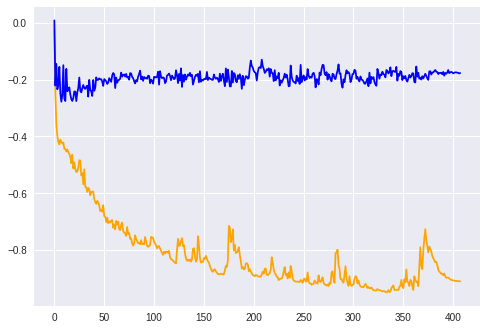

0.005
50
10


InvalidArgumentError: ignored

In [0]:
# Full predicition - NEW VERSION

INIT_T = 3000
TEST_T = 1200


BATCH_SIZE = 50
N_NEURONS = 10
LR = 0.01


N_EPOCHS = 1000
TIMESTEPS = 60
REPEATS = 1


### ITERATION !!!!!!!!!!
t = 4



# loss = negative_profit_avg
loss = negative_profit_avg_no_fees

folder_id = '16tTA6nYMh4ao4bI6qb2-gHXIMFefOE4M'



n_neurons=N_NEURONS
batch_size=BATCH_SIZE
features=1
timesteps = TIMESTEPS
lr = LR


train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

# # Rescale
#import math
# Calculate MAX_ABS for the first iteration and test (simply Rescale). 
# Find the biggest value for training dataset (without validation set)
MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-600]).max()))
MAX_ABS = MAX_ABS/20

TRANSACTION_SIZE = 300000/MAX_ABS/20
#TRANSACTION_SIZE = 300000/MAX_ABS

X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS



# X_train = encoder.predict(X_train, batch_size = BATCH_SIZE)
# X_test = encoder.predict(X_test, batch_size = BATCH_SIZE)
# X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
# X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)


def negative_profit_avg(y_true, #future_price_change
                y_pred, #action
                FEE = FEE,
                TRANSACTION_SIZE = TRANSACTION_SIZE): 
  lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
  profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
  loss = -profit
  return loss




##### 
#import time
# keras.initializers.glorot_uniform(seed=111)

timestr_f = time.strftime("%Y%m%d-%H%M%S")

#     clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.005,
#                            step_size=20., mode='exp_range',
#                            gamma=0.99998)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000, patience=400, verbose=0, mode='min', baseline=None)

filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=40, min_lr=0.00000000001)

#plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)

print(t)
print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df)))

#model.reset_states() 

#     ####### BUILD MODEL TO RESET WEIGHTS
#     model = Sequential()
#     model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
#                        ))
#     model.add(Dense(1, activation='tanh'))
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
#     ####### end_of: BUILD MODEL TO RESET WEIGHTS

# model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = loss,
#                   n_neurons = N_NEURONS, lr = LR)

model = build_model_stacked(TIMESTEPS, batch_size = BATCH_SIZE, loss = loss,
                  n_neurons = N_NEURONS, lr = LR)


#model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
model.fit(X_train, y_train,
      epochs=N_EPOCHS,
      batch_size=BATCH_SIZE,
      shuffle=True,
      validation_split=0.2, # if training 15k then split into 12k train 3k validation
        callbacks=[checkpoint, checkpoint_loss,  plot_losses,# clr_triangular, 
                   early_stop , reduce_lr],
          verbose=1
         )

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.load_weights("weights_f.best.hdf5")
model.load_weights(filepath_f)
model.compile(loss=loss, optimizer=adam)


pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test = np.column_stack((y_test, pred_temp))
# yhat_test_temp = np.column_stack((y_test, pred_temp))
# yhat_test = np.concatenate((yhat_test, yhat_test_temp))




##### SAVING #######
# FOLDER_ID !!!
folder_id = folder_id

##### Save plot to Drive

comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")


file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))



# ##### Increase t
#     t += 1



In [0]:
yhat_test_4 = yhat_test

In [0]:


pred_temp = model.predict(X_test[:600], batch_size = BATCH_SIZE)
yhat_test = np.column_stack((y_test[:600], pred_temp))
# yhat_test_temp = np.column_stack((y_test, pred_temp))
# yhat_test = np.concatenate((yhat_test, yhat_test_temp))


##### SAVING #######
# FOLDER_ID !!!

folder_id = folder_id

##### Save plot to Drive

comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")


file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))



File ID: 1icbru5KT5ESw6a2qo3wpbre9s2bOdw_G
File ID: 1NO0mwxcPPHwUkCSSYM7DUdXcRJ0pdLE8


### Change LSTM RL loss function - Sharpe Ratio


20190103-135359_iter_3_


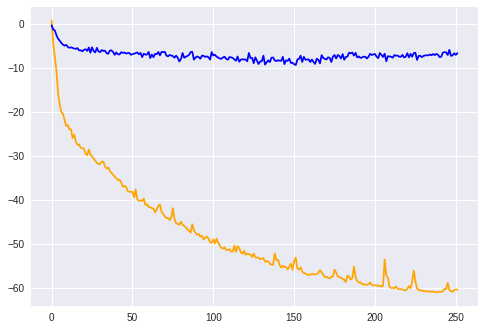

0.001
50
60
File ID: 1QoUF4We8qi7CMU1edR7KHCipR9QT6gkP
File ID: 15Z5JHD0hzMEig2WTXnoffeMAvOYBMaTP


In [0]:
INIT_T = 3000
TEST_T = 1200


BATCH_SIZE = 50
N_NEURONS = 60
LR = 0.001


N_EPOCHS = 1000
TIMESTEPS = 60
REPEATS = 1


#TRANSACTION_SIZE = 0



# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE

#loss = negative_profit_avg
#loss = negative_sharpe_ratio
loss = negative_utility


folder_id = '1ZHK-MSroan01EmTQYbgTX_zAWaLRjBnI'




features=1
timesteps = TIMESTEPS
lr = LR


##### SET T manually (from 0 to 4) for the iteration
t = 3



train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

# # Rescale
# X_train = X_train/MAX_ABS
# y_train = y_train/MAX_ABS
# X_test = X_test/MAX_ABS
# y_test = y_test/MAX_ABS


#import math
# Calculate MAX_ABS for the first iteration and test (simply Rescale). 
# Find the biggest value for training dataset (without validation set)
MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-600]).max()))
MAX_ABS = MAX_ABS/20

TRANSACTION_SIZE = 300000/MAX_ABS/20
#TRANSACTION_SIZE = 300000/MAX_ABS

X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS


# def negative_profit_avg(y_true, #future_price_change
#                 y_pred, #action
#                 FEE = FEE,
#                 TRANSACTION_SIZE = TRANSACTION_SIZE): 
#   lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
#   profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
#   loss = -profit
#   return loss

  
#   # avg_profit/std_profit
# def negative_sharpe_ratio(y_true, #future_price_change
#                           y_pred, #action
#                           FEE = FEE,
#                           TRANSACTION_SIZE = TRANSACTION_SIZE): 
    
#     lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
#     avg_profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(TRANSACTION_SIZE)*K.constant(FEE)
#     std_profit = K.std(y_pred*y_true) + K.epsilon()
    
#     sharpe_ratio = avg_profit/std_profit
    
                         
#     loss = -sharpe_ratio
#     return loss

  

# Utility function based on Dempster (2006)
def negative_utility(y_true, #future_price_change
                     y_pred, #action
                     FEE = FEE,
                     TRANSACTION_SIZE = TRANSACTION_SIZE,
                     Z = 100, #for sharpening the indicator function
                     V = 0.25, #trader's personal risk aversion
                     A = 100): #constant
                     
    #use sigmoid as indicator function https://en.wikipedia.org/wiki/Heaviside_step_function#Analytic_approximations
    risk_measure = K.sum(K.square(y_pred*y_true)*K.sigmoid(-y_pred*y_true*K.constant(Z)))/(K.sum(K.square(y_pred*y_true)*K.sigmoid(y_pred*y_true*K.constant(Z))) + K.epsilon())
    
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    avg_profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(TRANSACTION_SIZE)*K.constant(FEE)
    
    utility = A*(1-V)*avg_profit - V*risk_measure
                         
    loss = -utility
    return loss  
  


##### 
import time
keras.initializers.glorot_uniform(seed=666)

timestr_f = time.strftime("%Y%m%d-%H%M%S")

#     clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.005,
#                            step_size=20., mode='exp_range',
#                            gamma=0.99998)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000, patience=100, verbose=0, mode='min', baseline=None)

filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.00000000001)

#plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)

print(t)
print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df)))

#model.reset_states() 

#     ####### BUILD MODEL TO RESET WEIGHTS
#     model = Sequential()
#     model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
#                        ))
#     model.add(Dense(1, activation='tanh'))
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
#     ####### end_of: BUILD MODEL TO RESET WEIGHTS

model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = loss, n_neurons = N_NEURONS, lr = LR)


#model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
model.fit(X_train, y_train,
      epochs=N_EPOCHS,
      batch_size=BATCH_SIZE,
      shuffle=True,
      validation_split=0.2, # if training 15k then split into 12k train 3k validation
        callbacks=[checkpoint, checkpoint_loss,  plot_losses,# clr_triangular, 
                   early_stop , reduce_lr],
          verbose=1
         )

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.load_weights("weights_f.best.hdf5")
model.load_weights(filepath_f)
model.compile(loss=loss, optimizer=adam)


pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test = np.column_stack((y_test, pred_temp))

# yhat_test_temp = np.column_stack((y_test, pred_temp))
# yhat_test = np.concatenate((yhat_test, yhat_test_temp))




##### SAVING #######
# FOLDER_ID !!!
# folder_id = '1DJN3hlZXZj7pmxPhsDrMetMGBFpBKuAy'
folder_id = folder_id

##### Save plot to Drive
comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")


file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


In [0]:
yhat_test_2 = yhat_test

In [0]:
X_test.shape

(630, 60, 1)

In [0]:
X_test[:600].shape

(600, 60, 1)

In [0]:


pred_temp = model.predict(X_test[:600], batch_size = BATCH_SIZE)
yhat_test = np.column_stack((y_test[:600], pred_temp))

# yhat_test_temp = np.column_stack((y_test, pred_temp))
# yhat_test = np.concatenate((yhat_test, yhat_test_temp))




##### SAVING #######
# FOLDER_ID !!!
# folder_id = '1DJN3hlZXZj7pmxPhsDrMetMGBFpBKuAy'
folder_id = folder_id

##### Save plot to Drive
comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")


file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


File ID: 1lVzXf141pIPA19_HAQZrfcSjfqRR421I
File ID: 1n1OJCvNq3EcoOWJYyDnHi3IO-YfEqRPx


# Train FULL model with iteratins - broken after 12 iterations

In [0]:
BATCH_SIZE = 5
N_NEURONS = 60
LR = 0.0001


N_EPOCHS = 1000
TIMESTEPS = 60
REPEATS = 1


#TRANSACTION_SIZE = 0



# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = negative_profit_avg
features=1
timesteps = TIMESTEPS
lr = LR


model.reset_states() 
##### BUILD MODEL with saved weights

# model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
# model.reset_states()

model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath)
model.compile(loss=loss, optimizer=adam)
######


#####  Don't train the model for the first round (use from saved weights from above)
t = 0
yhat_test = np.empty((0,2), float)


#### Rebuild the original test/train set
train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

# # Rescale
# X_train = X_train/MAX_ABS
# y_train = y_train/MAX_ABS
# X_test = X_test/MAX_ABS
# y_test = y_test/MAX_ABS


#import math
# Calculate MAX_ABS for the first iteration and test (simply Rescale). 
# Find the biggest value for training dataset (without validation set)
MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-200]).max()))
TRANSACTION_SIZE = 300000/MAX_ABS/20

X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS


def negative_profit_avg(y_true, #future_price_change
                    y_pred, #action
                    FEE = FEE,
                    TRANSACTION_SIZE = TRANSACTION_SIZE): 
  
    lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
    profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
    loss = -profit
    return loss
#- (K.sum(action*future_price) - FEE* K.abs(action - prev_output))



####### model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
# yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
# yhat_test = np.append(yhat_test, yhat_test_temp)
pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test_temp = np.column_stack((y_test, pred_temp))
yhat_test = np.concatenate((yhat_test, yhat_test_temp))


t += 1


###### Loop for further iterations
while ((INIT_T + TEST_T*t + TEST_T) <= len(full_df)):

    train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
    test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

    X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
    X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

    X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
    X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)

    # # Rescale
    # X_train = X_train/MAX_ABS
    # y_train = y_train/MAX_ABS
    # X_test = X_test/MAX_ABS
    # y_test = y_test/MAX_ABS


    #import math
    # Calculate MAX_ABS for the first iteration and test (simply Rescale). 
    # Find the biggest value for training dataset (without validation set)
    MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-200]).max()))
    TRANSACTION_SIZE = 300000/MAX_ABS/20

    X_train = X_train_pre/MAX_ABS
    y_train = y_train_pre/MAX_ABS
    X_test = X_test_pre/MAX_ABS
    y_test = y_test_pre/MAX_ABS




##### import time
    timestr_f = time.strftime("%Y%m%d-%H%M%S")
  
    clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.001,
                           step_size=20., mode='exp_range',
                           gamma=0.99998)
  
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=35, verbose=0, mode='min', baseline=None)
    
    filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
    checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')
   
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)
    
    #plot_losses = PlotLosses(REPEATS)
    plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)
    
    print(t)
    print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df)))
    
    model.reset_states() 

    ####### BUILD MODEL TO RESET WEIGHTS
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                       ))
    model.add(Dense(1, activation='tanh'))
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    ####### end_of: BUILD MODEL TO RESET WEIGHTS
    
    
    #model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
    model.fit(X_train, y_train,
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=False,
          validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[checkpoint, checkpoint_loss,  plot_losses, clr_triangular, early_stop #, reduce_lr
                      ],
          verbose=1)

    
    #model.load_weights("weights_f.best.hdf5")
    model.load_weights(filepath_f)
    model.compile(loss=loss, optimizer=adam)
    
  
#     yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
#     yhat_test = np.append(yhat_test, yhat_test_temp)
    pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
    yhat_test_temp = np.column_stack((y_test, pred_temp))
    yhat_test = np.concatenate((yhat_test, yhat_test_temp))
    

##### SAVING #######
# FOLDER_ID !!!
    folder_id = '1nEB7XreX92hyNiGYb5nwmjLy6PBntb1c'
    
##### Save plot to Drive
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
    comment = ("_iter_" + str(t) + "_")
    filename_plot = timestr_f + comment + "_loss_plot.png"

    file_metadata = {
        'name': filename_plot,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                            mimetype='image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
    
    
##### Save predicition results to csv to Drive
    csvfile = (timestr_f + "_yhat_test.csv")
    np.savetxt(csvfile, yhat_test, delimiter=",")
    
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

    file_metadata = {
        'name': csvfile,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                            mimetype='text/plain', #'image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
      
    
##### Increase t
    t += 1


In [0]:
yhat_test

# Train FULL model with Iterations - broken after 10 iterations

20180910-161754_iter_17_


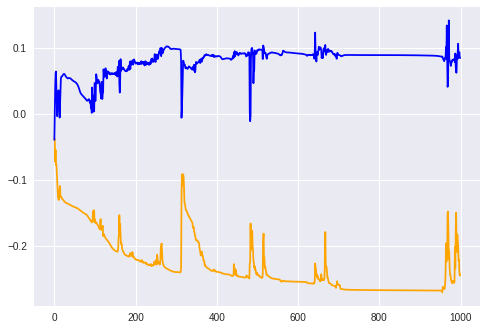

1e-04
200
File ID: 10ERpZ0vWV0UzC1Iwxxv06tgukIRr4ZlZ
File ID: 1hV3YIkRtaXfgzH50-_Aw5EqgKxK50OuX


In [0]:

BATCH_SIZE = 200
TIMESTEPS = 60
N_NEURONS = 60


N_EPOCHS = 1000


# Full predicition - NEW VERSION, continue from 10th iteration

BATCH_SIZE = 200
N_NEURONS = 60
LR = 0.0003

REPEATS = 1


n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = negative_profit_avg
features=1
timesteps = TIMESTEPS
lr = LR


clr_triangular  = CyclicLR(base_lr=0.0001, max_lr=0.0005,
                           step_size=50., mode='exp_range',
                           gamma=0.99998)



# model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
# model.reset_states()


model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights("20180910-133432_weights_f.best.hdf5")
model.compile(loss=loss, optimizer=adam)
######



#t = 10
#yhat_test = np.empty((0,1), float)


while ((INIT_T + TEST_T*t + TEST_T) <= len(full_df)):

    train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
    test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

    X_train, y_train = train[:, :INPUT_VARS], train[:, -1]
    X_test, y_test = test[:, :INPUT_VARS], test[:, -1]

    X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
    X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)

    # Rescale
    X_train = X_train/MAX_ABS
    y_train = y_train/MAX_ABS
    X_test = X_test/MAX_ABS
    y_test = y_test/MAX_ABS

    
    #reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)

    #import time
    timestr_f = time.strftime("%Y%m%d-%H%M%S")    
    
    filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
    checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')
    
    
    #plot_losses = PlotLosses(REPEATS)
    plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)
    
    print(t)
    print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df)))

    
    #model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
    model.fit(X_train, y_train,
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=False,
          validation_split=0.2, # if training 15k then split into 12k train 3k validation
          callbacks=[checkpoint, checkpoint_loss,  plot_losses, clr_triangular#, reduce_lr
                    ],
          verbose=1)

    
    #model.load_weights("weights_f.best.hdf5")
    model.load_weights(filepath_f)
    model.compile(loss=loss, optimizer=adam)
    
  
    yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
    yhat_test = np.append(yhat_test, yhat_test_temp)
    
    
    #Save plot to Drive
    folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
    comment = ("_iter_" + str(t) + "_")
    filename_plot = timestr_f + comment + "_loss_plot.png"

    file_metadata = {
        'name': filename_plot,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                            mimetype='image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()

    print('File ID: {}'.format(file.get('id')))
    
    
    # Save predicition results to csv to Drive
    csvfile = (timestr_f + "_yhat_test.csv")
    np.savetxt(csvfile, yhat_test, delimiter=",")
    
    folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

    file_metadata = {
        'name': csvfile,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                            mimetype='text/plain', #'image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()

    print('File ID: {}'.format(file.get('id')))
      
    
    #Increase t
    t += 1



In [0]:
t

11

In [0]:
yhat_test = np.empty((0,1), float)

yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test = np.append(yhat_test, yhat_test_temp)


#Save plot to Drive
folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))


# Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")

folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))


#Increase t
t += 1


File ID: 1El6vFQMk4QJM9wRtTCS9CjF5V3UKjS1a
File ID: 1KMhYWuq9846uqDdSfctDTRpeDGupSIvu


# AUTOENCODER

In [0]:
#####################################################
#  BUILD AUTOENCODER!!!!


def build_ae(TIMESTEPS, LATENT_DIM = 5, INPUT_DIM=1, lr = 0.001):
    inputs = Input(shape=(TIMESTEPS, INPUT_DIM))
    
#     encoded = CuDNNLSTM(LATENT_DIM)(inputs)
    encoded = CuDNNLSTM(LATENT_DIM, activity_regularizer=regularizers.l1(10e-5))(inputs)
    #h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)

    decoded = RepeatVector(TIMESTEPS)(encoded)
    decoded = CuDNNLSTM(INPUT_DIM, return_sequences=True)(decoded)

    sequence_autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    sequence_autoencoder.compile(loss='MSE', optimizer=adam)
    
#     RMSprop = keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
#     sequence_autoencoder.compile(optimizer=RMSprop, loss='MSE')
    return sequence_autoencoder

20190103-222514_iter_0_


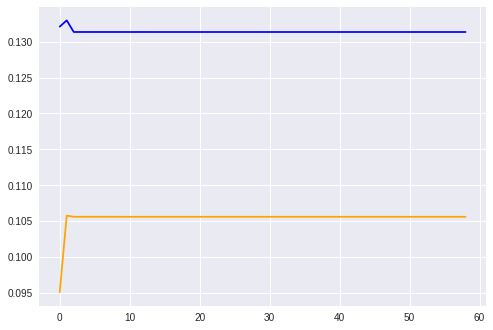

4.8828126e-05
50
60
Epoch 60/200
2050/2400 [========================>.....] - ETA: 0s - loss: 0.1057

KeyboardInterrupt: ignored

In [0]:
#####################################################
#  FIT AUTOENCODER!!!!
BATCH_SIZE = 50

TIMESTEPS = 60
INPUT_DIM = 1
LATENT_DIM = 60
N_NEURONS = LATENT_DIM

N_EPOCHS = 200

lr = 0.1


timestr_f = time.strftime("%Y%m%d-%H%M%S")
REPEATS = 1

t = 0

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000, patience=20, verbose=0, mode='min', baseline=None)

filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0000000000001)

# plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)


#sequence_autoencoder = build_ae(TIMESTEPS, LATENT_DIM = LATENT_DIM, INPUT_DIM=INPUT_DIM, lr = lr)
inputs = Input(shape=(TIMESTEPS, INPUT_DIM))

#encoded = CuDNNLSTM(LATENT_DIM)(inputs)
encoded = CuDNNLSTM(LATENT_DIM, activity_regularizer=regularizers.l1(10e-5))(inputs)
#h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)

decoded = RepeatVector(TIMESTEPS)(encoded)
decoded = CuDNNLSTM(INPUT_DIM, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
sequence_autoencoder.compile(loss='MSE', optimizer=adam)
    

noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=0.05, size=X_train.shape) 

#X_train_noisy = np.clip(X_train_noisy, 0., 1.)

sequence_autoencoder.fit(X_train_noisy, X_train,
                         epochs=N_EPOCHS,
                         shuffle=True,
                         batch_size=BATCH_SIZE,
                         validation_split=0.2, # if training 15k then split into 12k train 3k validation
                         callbacks=[checkpoint, checkpoint_loss,  plot_losses,# clr_triangular, 
                                     early_stop , reduce_lr],
                         verbose=1)

####
#encoded_data=encoder.predict(X_train)

In [0]:
#from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [0]:
BATCH_SIZE = 300

TIMESTEPS = 60
INPUT_DIM = 1
LATENT_DIM = 5

REPEATS = 1  
  
  
inputs = Input(batch_shape=(BATCH_SIZE, TIMESTEPS, INPUT_DIM))
encoded = CuDNNLSTM(LATENT_DIM, stateful=False)(inputs)
#encoded = LSTM(LATENT_DIM, activity_regularizer=regularizers.l1(10e-5))(inputs)
#h = Dense(hidden_size, activation='relu', activity_regularizer=regularizers.l1(10e-5))(x)

decoded = RepeatVector(TIMESTEPS)(encoded)
decoded = CuDNNLSTM(INPUT_DIM, return_sequences=True, stateful=False)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)

RMSprop = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

sequence_autoencoder.compile(optimizer=RMSprop, loss='MSE')



plot_losses = PlotLosses(REPEATS)

for i in range(REPEATS):
    
    noise_factor = 1
    X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=0.5, size=X_train.shape) 

    X_train_noisy = np.clip(X_train_noisy, 0., 1.)
    
    sequence_autoencoder.fit(X_train_noisy, X_train,
                             epochs=50,
                             shuffle=False,
                             batch_size=BATCH_SIZE,
                             validation_split=0.2, # if training 15k then split into 12k train 3k validation
                             callbacks=[plot_losses],
                             verbose=1)


In [0]:
X_train_encoded = encoder.predict(X_train, batch_size = BATCH_SIZE)

In [0]:
X_train.shape

(1000, 60, 1)

In [0]:
X_train_encoded.shape

(1000, 60)

In [0]:
X_train

array([[[ 1.0997097e-05],
        [-7.8100647e-06],
        [ 6.7275637e-06],
        ...,
        [-1.6007027e-05],
        [ 9.6275317e-06],
        [ 1.8959776e-05]],

       [[ 3.3226040e-06],
        [-3.4664756e-06],
        [ 3.1083730e-06],
        ...,
        [-5.8624655e-06],
        [ 3.2099822e-06],
        [ 6.1553401e-06]],

       [[ 2.2888316e-05],
        [-2.0250673e-05],
        [ 1.7882836e-05],
        ...,
        [-3.5895580e-05],
        [ 2.1883030e-05],
        [ 4.0448245e-05]],

       ...,

       [[ 6.5767113e-04],
        [-3.5780917e-03],
        [ 1.6405043e-03],
        ...,
        [-4.3305070e-03],
        [ 2.3633668e-03],
        [ 8.3682040e-04]],

       [[ 1.3391095e-01],
        [-2.3778427e-01],
        [ 1.6676752e-01],
        ...,
        [-4.3210468e-01],
        [ 3.9016327e-01],
        [ 1.3545370e-01]],

       [[ 1.9685249e-05],
        [-2.3330815e-05],
        [ 9.7376069e-06],
        ...,
        [-1.6129074e-04],
        [ 2.314

In [0]:
X_train_encoded

array([[ 1.3140277e-05, -1.1413805e-05,  1.0019699e-05, ...,
        -2.0685218e-05,  1.2328309e-05,  2.3290904e-05],
       [ 1.1834280e-05, -1.0641073e-05,  9.3682502e-06, ...,
        -1.8943365e-05,  1.1202329e-05,  2.1108654e-05],
       [ 1.4057497e-05, -1.2455553e-05,  1.0958826e-05, ...,
        -2.2278995e-05,  1.3294536e-05,  2.4972904e-05],
       ...,
       [ 1.0561605e-05, -8.7221661e-06,  7.6152583e-06, ...,
        -1.6368247e-05,  9.7016518e-06,  1.8626113e-05],
       [ 1.0002071e-05, -8.0741356e-06,  7.0336032e-06, ...,
        -1.5378964e-05,  9.1103611e-06,  1.7592287e-05],
       [ 8.5354159e-06, -7.0632459e-06,  6.1696960e-06, ...,
        -1.3317106e-05,  7.8094045e-06,  1.5098344e-05]], dtype=float32)

In [0]:
X_train_encoded = X_train_encoded.reshape(X_train_encoded.shape[0], X_train_encoded.shape[1], 1)

In [0]:

X_train_encoded = encoder.predict(X_train, batch_size = BATCH_SIZE)


In [0]:
X_train_encoded.shape

(3000, 30)

In [0]:
X_train.shape

(3000, 60, 1)

# Train model with AE processed data

In [0]:
BATCH_SIZE = 2000
N_NEURONS = 60

REPEATS = 2


#plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS)

for i in range(REPEATS):
  print (i+1)
  model = build_model(X_train_encoded.shape[1], batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
  model.fit(X_train_encoded, y_train,
            epochs=150,
            batch_size=BATCH_SIZE,
            shuffle=False,
            validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[plot_losses],
            verbose=1)
  model.reset_states()
    

In [0]:
BATCH_SIZE = 200
TIMESTEPS = 60
N_NEURONS = 60
N_EPOCHS = 1000


# Full predicition



t = 0

yhat_test = np.empty((0,1), float)

model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
model.reset_states()


while ((INIT_T + TEST_T*t + TEST_T) <= len(full_df)):

    train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
    test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

    X_train, y_train = train[:, :INPUT_VARS], train[:, -1]
    X_test, y_test = test[:, :INPUT_VARS], test[:, -1]

    X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
    X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)

    # Rescale
    X_train = X_train/MAX_ABS
    y_train = y_train/MAX_ABS
    X_test = X_test/MAX_ABS
    y_test = y_test/MAX_ABS

    model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
    yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
    yhat_test = np.append(yhat_test, yhat_test_temp)

    t += 1


# Check the iteration LSTM RL (Sharpe Ratio) - manual batch50

In [0]:

yhat_test_0 = pd.DataFrame(yhat_test_0)
yhat_test_1 = pd.DataFrame(yhat_test_1)
yhat_test_2 = pd.DataFrame(yhat_test_2)
yhat_test_3 = pd.DataFrame(yhat_test_3)
yhat_test_4 = pd.DataFrame(yhat_test_4)



(600, 2)

In [0]:
yhat_test_lstm_rl_sharpe = yhat_test_0.append([yhat_test_1, yhat_test_2, yhat_test_3, yhat_test_4])
yhat_test_lstm_rl_sharpe.shape


(5400, 2)

In [0]:
yhat_test_lstm_rl_sharpe.shape

(9600, 10)

In [0]:

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload




##### SAVING #######
# FOLDER_ID !!!
#folder_id = '1aaNkQDjXt_KjJzPf4BQBEmc0buhQJ9BP'
folder_id = folder_id

##### Save predicition results to csv to Drive
csvfile = "20190104-yhat_test_rnn_rl_50_batch_stacked_FULL_60neurons.csv"
np.savetxt(csvfile, yhat_test_lstm_rl_sharpe, delimiter=",")

file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))

File ID: 10dpb23b5_aGD9h3Tka5XVrPYI1wGrJeH


# Check the iteration RNN RL manual

In [0]:
#### OPTIONAL

#2. Get the file
downloaded0 = drive.CreateFile({'id':'1zKmrktSJgEFZkDPLr28Z8kwLiwkHm8GC'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded0.GetContentFile('20190101-224030_yhat_test.csv')  

downloaded1 = drive.CreateFile({'id':'1LobxzObXj_-D1iGnUriTt-up-JPp3D-K'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded1.GetContentFile('20190102-080347_yhat_test.csv')  


# downloaded2 = drive.CreateFile({'id':'1sPhUvGZiOzvMfBUwLVcMZVlzS9g1PtNI'}) # replace the id with id of FILE you want to access (not folder-id)
# downloaded2.GetContentFile('20190102-103959_yhat_test.csv') 

downloaded2 = drive.CreateFile({'id':'1Mxcavs1fPUCYHgEgqytQY-AE4trYSGLI'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded2.GetContentFile('20190102-094642_yhat_test.csv')  


downloaded3 = drive.CreateFile({'id':'1n44UNUGPDU0lStBwBI2Z33aof-cuu9Od'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded3.GetContentFile('20190102-122110_yhat_test.csv')

downloaded4 = drive.CreateFile({'id':'1wAA1IswCclfRT2iEK5EvylwxQpjMiOFc'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded4.GetContentFile('20190102-131707_yhat_test.csv')  


#3. Read file as panda dataframe
#import pandas as pd
yhat_test_csv_rnn_rl_0 = pd.read_csv('20190101-224030_yhat_test.csv',header=None) 
yhat_test_csv_rnn_rl_1 = pd.read_csv('20190102-080347_yhat_test.csv',header=None) 
# yhat_test_csv_rnn_rl_2 = pd.read_csv('20190102-103959_yhat_test.csv',header=None)
yhat_test_csv_rnn_rl_2 = pd.read_csv('20190102-094642_yhat_test.csv',header=None)
yhat_test_csv_rnn_rl_3 = pd.read_csv('20190102-122110_yhat_test.csv',header=None) 
yhat_test_csv_rnn_rl_4 = pd.read_csv('20190102-131707_yhat_test.csv',header=None) 


yhat_test_csv_rnn_rl_0.shape


yhat_test_csv_rnn_rl = yhat_test_csv_rnn_rl_0.append([yhat_test_csv_rnn_rl_1, yhat_test_csv_rnn_rl_2, yhat_test_csv_rnn_rl_3, yhat_test_csv_rnn_rl_4])
yhat_test_csv_rnn_rl




In [0]:
downloaded1 = drive.CreateFile({'id':'1pk59V0rnYkBuFJ8YDXfYPUf737k29bk3'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded1.GetContentFile('20190104-125037_yhat_test.csv')
yhat_test_1 = pd.read_csv('20190104-125037_yhat_test.csv',header=None) 

In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload


##### SAVING #######
# FOLDER_ID !!!
folder_id = '1VvyXXqsIWoXGWimh0Lf1QHJEBPeN_KJg'


##### Save predicition results to csv to Drive
csvfile = "20190102-yhat_test_csv_rnn_rl_FULL.csv"
np.savetxt(csvfile, yhat_test_csv_rnn_rl, delimiter=",")

file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


File ID: 1tbUqs4X7Uc5KUGQ2K2Yb4w1UOxEdTN3d


# Actions from results and cum_profit

In [0]:
#### OPTIONAL

#2. Get the file
downloaded = drive.CreateFile({'id':'1ruKl1v0ua4EJdt5UJwlVpG3FBIyJtaXy'}) # replace the id with id of file you want to access
downloaded.GetContentFile('20181230-174215_yhat_test.csv')  

#3. Read file as panda dataframe
#import pandas as pd
yhat_test_csv = pd.read_csv('20181230-174215_yhat_test.csv',header=None) 

yhat_test_csv.shape

(5430, 2)

In [0]:
yhat_test_csv = pd.DataFrame(yhat_test_csv)

In [0]:
yhat_test_csv = pd.DataFrame(yhat_test_lstm_rl_sharpe)

In [0]:
yhat_test_csv.iloc[:,1:].shape

(5430, 1)

In [0]:
#yhat_test_csv = yhat_test_csv[1]

In [0]:
yhat_test_csv.shape

(7200,)

In [0]:
y_test_pre.shape

(400,)

In [0]:
pd.DataFrame(full_df[INIT_T:(INIT_T + 18*TEST_T), -1:]).shape

(5430, 1)

In [0]:
yhat_test_df = np.column_stack((pd.DataFrame(full_df[INIT_T:(INIT_T + 18*TEST_T), -1:]), yhat_test_csv.iloc[:,1:]))

In [0]:
pd.DataFrame(full_df[INIT_T:(INIT_T + 5400), -1:]).shape

(5400, 1)

In [0]:
yhat_test_df = np.column_stack((pd.DataFrame(full_df[INIT_T:(INIT_T + 5400), -1:]), yhat_test_lstm_rl_sharpe.iloc[:,1:]))

In [0]:
#### Check results of 2 dim df from 17 iterations
yhat_test_csv.iloc[:10,:]

In [0]:
def action_from_results_df(yhat_test_pre, THRESHOLD = 0.33): # read yhat as numpy array, return as DF with columns: result, action
    yhat_test = pd.DataFrame(yhat_test_pre)
    pd.options.mode.chained_assignment = None
    #yhat_test = pd.DataFrame(yhat_test, columns=['result'])
    yhat_test.columns=['price', 'result']
    yhat_test['action'] = 1
    yhat_test['action'][(yhat_test.result < -THRESHOLD)] = -1
    yhat_test['action'][(yhat_test.result > -THRESHOLD) & (yhat_test.result < THRESHOLD)] = 0
    return yhat_test

#yhat_test_1 = action_from_results_df(yhat_test_csv, THRESHOLD = 0.33)


In [0]:
yhat_test_full_1 = action_from_results_df(yhat_test_df, THRESHOLD = 0.33)

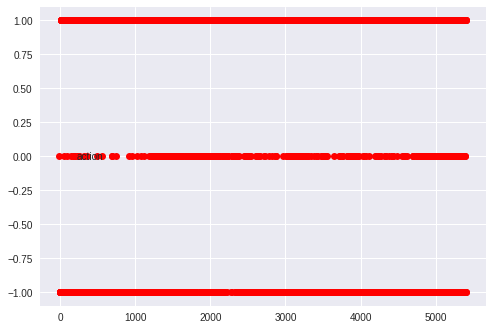

In [0]:
plt.plot(yhat_test_full_1['action'], 'ro')
plt.legend()
plt.show()

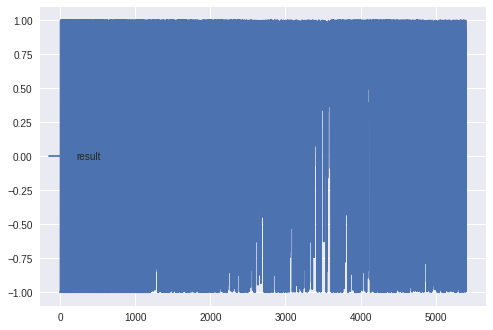

In [0]:
plt.plot(yhat_test_full_1['result'])
plt.legend()
plt.show()

In [0]:
FEE

0.0025

In [0]:
 # read yhat as DF with result and action, return as DF with added columns:price, action_diff, profit,cum_profit
def profit_from_result_df(yhat_test_pre, fee = FEE, transaction_size = 300000):    
    yhat_test = yhat_test_pre
    #yhat_test['price'] = y_test
    yhat_test['action_diff'] = yhat_test['action'].diff().abs()

    # We start from 0
    yhat_test['action_diff'][0] = yhat_test['action'][0]

#     yhat_test['profit'] = yhat_test['price']*yhat_test['action'] - yhat_test['action_diff'].abs()*fee*transaction_size
#     yhat_test['profit_cum'] = yhat_test['profit'].cumsum()
    
    yhat_test['profit_rescale'] = yhat_test['price']*yhat_test['action'] - yhat_test['action_diff'].abs()*fee*transaction_size
    yhat_test['profit_cum_rescale'] = yhat_test['profit_rescale'].cumsum()
    
    yhat_test['profit_rescale_1k'] = (yhat_test['price']*yhat_test['action'] - yhat_test['action_diff'].abs()*fee*transaction_size)/1000
    yhat_test['profit_cum_rescale_1k'] = (yhat_test['profit_rescale'].cumsum())/1000
    
    
    return yhat_test


#yhat_test_2 = profit_from_result_df(yhat_test_1)

In [0]:
yhat_test_full_2 = profit_from_result_df(yhat_test_full_1)

In [0]:
FEE

0.0025

In [0]:
TRANSACTION_SIZE*MAX_ABS

15000.0

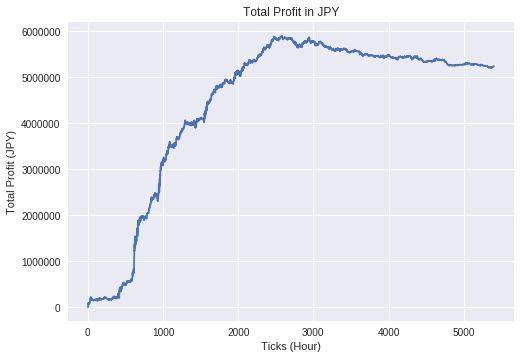

In [0]:
plt.plot(yhat_test_full_2['profit_cum_rescale']) #, label = 'profit_cum_rescale')
plt.xlabel("Ticks (Hour)")
plt.ylabel("Total Profit (JPY)")
plt.title("Total Profit in JPY")
#plt.legend()
plt.show()

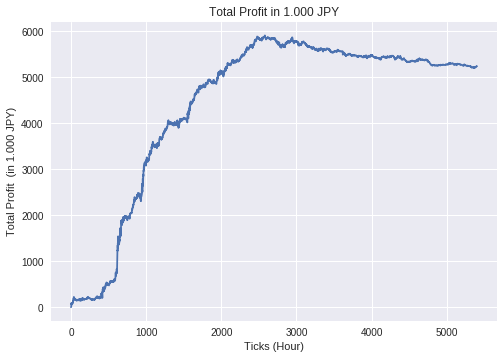

In [0]:
plt.plot(yhat_test_full_2['profit_cum_rescale_1k']) #, label = 'profit_cum_rescale')
plt.xlabel("Ticks (Hour)")
plt.ylabel("Total Profit  (in 1.000 JPY)")
plt.title("Total Profit in 1.000 JPY")
#plt.legend()
plt.show()

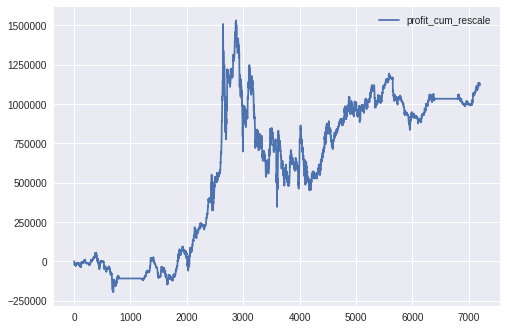

In [0]:
plt.plot(yhat_test_2['profit_cum_rescale'], label = 'profit_cum_rescale')
plt.legend()
plt.show()

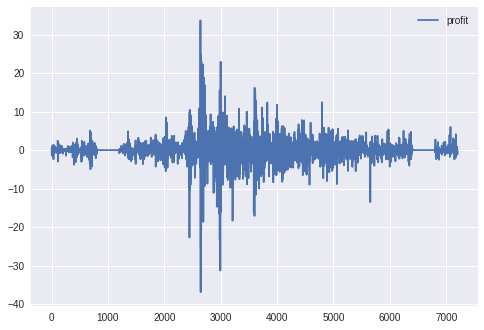

In [0]:
plt.plot(yhat_test_2['profit'], label = 'profit')
plt.legend()
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f875b5c2208>],
 'caps': [<matplotlib.lines.Line2D at 0x7f875b5c2cc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f875b54da20>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f875b54d5c0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f875b5c2390>,
  <matplotlib.lines.Line2D at 0x7f875b5c2860>]}

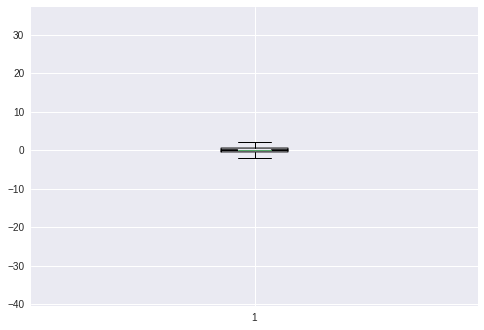

In [0]:
plt.figure()
plt.boxplot(yhat_test_2['profit'], 1)

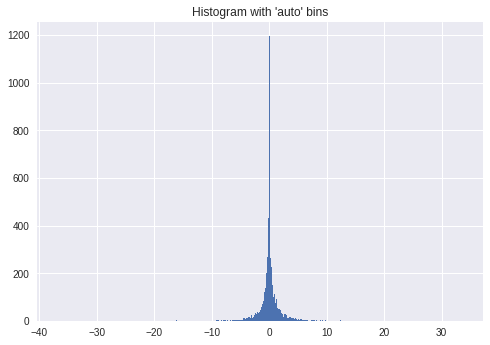

In [0]:
>>> plt.hist(yhat_test_2['profit'], bins='auto')  # arguments are passed to np.histogram
>>> plt.title("Histogram with 'auto' bins")
>>> plt.show()

# Actions from result - for 1 dim array

In [0]:
def action_from_results(yhat_test, THRESHOLD = 0.33): # read yhat as numpy array, return as DF with columns: result, action
    pd.options.mode.chained_assignment = None
    yhat_test = pd.DataFrame(yhat_test, columns=['result'])
    yhat_test['action'] = 1
    yhat_test['action'][(yhat_test.result < -THRESHOLD)] = -1
    yhat_test['action'][(yhat_test.result > -THRESHOLD) & (yhat_test.result < THRESHOLD)] = 0
    return yhat_test

yhat_test_1 = action_from_results(yhat_test, THRESHOLD = 0.33)


In [0]:
 # read yhat as DF with result and action, return as DF with added columns:price, action_diff, profit,cum_profit
def profit_from_result(yhat_test, y_test, fee = FEE, transaction_size = TRANSACTION_SIZE, max_abs = MAX_ABS):    
    yhat_test['price'] = y_test
    yhat_test['action_diff'] = yhat_test['action'].diff()

    # We start from 0
    yhat_test['action_diff'][0] = yhat_test['action'][0]

    yhat_test['profit'] = yhat_test['price']*yhat_test['action'] #- yhat_test['action_diff'].abs()*fee*transaction_size
    yhat_test['profit_cum'] = yhat_test['profit'].cumsum()
    
    yhat_test['profit_rescale'] = yhat_test['price']*yhat_test['action']*MAX_ABS #- yhat_test['action_diff'].abs()*fee*transaction_size*max_abs
    yhat_test['profit_cum_rescale'] = yhat_test['profit_rescale'].cumsum()
    return yhat_test

#y_test = full_df[INIT_T:,-1]/MAX_ABS
yhat_test_2 = profit_from_result(yhat_test_1, y_test)

# =>... RL model RNN - manual iterations

## Build RNN RL model - def

In [0]:

def build_model_rnn_rl(timesteps, n_neurons=6, batch_size=10, loss = negative_utility, features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(SimpleRNN(n_neurons, batch_input_shape=(batch_size, timesteps, features)))
    model.add(Dense(1, activation='tanh'))
    
    #model.compile(loss=loss, optimizer='adam')
    #model.compile(loss=loss, optimizer='RMSprop')   
    
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    
#     RMSprop = keras.optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=None, decay=0.0)
#     model.compile(loss=loss, optimizer=RMSprop)
    
    return model

In [0]:
t

4

20190104-201702_iter_4_


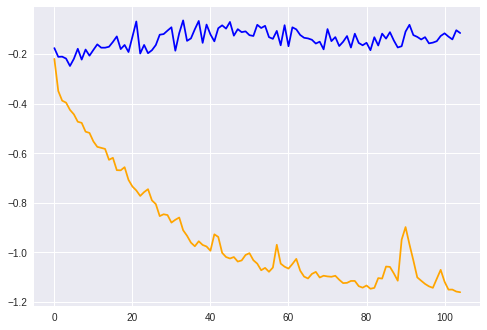

0.0005
50
60


InvalidArgumentError: ignored

In [0]:
INIT_T = 3000
TEST_T = 1200


BATCH_SIZE = 50
N_NEURONS = 60
LR = 0.001


N_EPOCHS = 1000
TIMESTEPS = 60
REPEATS = 1


# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = negative_profit_avg
features=1
timesteps = TIMESTEPS
lr = LR


###### ITERATION t=0 to 4
t = 4

folder_id = "1MrZ2cj__dvYtODOWTxWpRDnY9ivzUm1S"



train = full_df[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train_pre = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test_pre = test[:, :INPUT_VARS], test[:, -1]

X_train_pre = X_train_pre.reshape(X_train_pre.shape[0], TIMESTEPS, FEATURES)
X_test_pre = X_test_pre.reshape(X_test_pre.shape[0], TIMESTEPS, FEATURES)


#import math
# Calculate MAX_ABS for the first iteration and test (simply Rescale). 
# Find the biggest value for training dataset (without validation set)
MAX_ABS = math.ceil(float(np.abs(X_train_pre[:-600]).max()))
MAX_ABS = MAX_ABS/20

TRANSACTION_SIZE = 300000/MAX_ABS/20
#TRANSACTION_SIZE = 300000/MAX_ABS

X_train = X_train_pre/MAX_ABS
y_train = y_train_pre/MAX_ABS
X_test = X_test_pre/MAX_ABS
y_test = y_test_pre/MAX_ABS


def negative_profit_avg(y_true, #future_price_change
                y_pred, #action
                FEE = FEE,
                TRANSACTION_SIZE = TRANSACTION_SIZE): 
  lag_y_pred = K.abs(y_pred[1:,:] - y_pred[:-1,:])
  profit = K.mean(y_pred*y_true) - K.mean(lag_y_pred)*K.constant(FEE)*K.constant(TRANSACTION_SIZE)
  loss = -profit
  return loss


##### 
#import time
keras.initializers.glorot_uniform(seed=666)

timestr_f = time.strftime("%Y%m%d-%H%M%S")

#     clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.005,
#                            step_size=20., mode='exp_range',
#                            gamma=0.99998)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000, patience=100, verbose=0, mode='min', baseline=None)

filepath_f = timestr_f + "_" + "weights_f.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_f, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

filepath_loss_f = timestr_f + "_" + "weights_f.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f, monitor='loss', verbose=1, save_best_only=True, mode='min')


reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.00000000001)


plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)

print(t)
print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df)))


model = build_model_rnn_rl(TIMESTEPS, batch_size = BATCH_SIZE, loss = #negative_profit_avg_no_fees, #
                  negative_profit_avg,
                  #negative_profit_trading,
                  n_neurons = N_NEURONS, lr = LR)



model.fit(X_train, y_train,
      epochs=N_EPOCHS,
      batch_size=BATCH_SIZE,
      shuffle=True,
      validation_split=0.2, # if training 15k then split into 12k train 3k validation
        callbacks=[checkpoint, checkpoint_loss,  plot_losses,# clr_triangular, 
                   early_stop , reduce_lr],
          verbose=1
         )

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights_f.best.hdf5")
model.load_weights(filepath_f)
model.compile(loss=loss, optimizer=adam)


pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test = np.column_stack((y_test, pred_temp))

#yhat_test_temp = np.column_stack((y_test, pred_temp))
#yhat_test = np.concatenate((yhat_test, yhat_test_temp))



################################
###### SAVE TO DRIVE

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload



##### SAVING #######
# FOLDER_ID !!!
# folder_id = '16gzwCYtbLamE5Jtv6k9BxwMXTg1JV0nc'
folder_id = folder_id
##### Save plot to Drive

comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")


file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


In [0]:
yhat_test_4 = yhat_test

In [0]:


pred_temp = model.predict(X_test[:600], batch_size = BATCH_SIZE)
yhat_test = np.column_stack((y_test[:600], pred_temp))

# yhat_test_temp = np.column_stack((y_test, pred_temp))
# yhat_test = np.concatenate((yhat_test, yhat_test_temp))




##### SAVING #######
# FOLDER_ID !!!
# folder_id = '16gzwCYtbLamE5Jtv6k9BxwMXTg1JV0nc'
folder_id = folder_id

##### Save plot to Drive
comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")


file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


File ID: 1_NlpWb7DL5wrLqOv7LeWGCbxRlm5jiub
File ID: 1SAI_t4fBFIpCoqbkr0mO3z5zWEq8QF86


#.....BUILD SL model - LSTM




In [0]:
# Recode as SL problem

full_df_sl = pd.DataFrame(full_df)


#full_df_sl.loc[full_df_sl.loc[:,60] == 0]
# delete 37 obs with zero change
full_df_sl = full_df_sl.drop(full_df_sl[full_df_sl.loc[:,60] == 0].index)

pd.options.mode.chained_assignment = None
full_df_sl['change_ind'] = 1
full_df_sl['change_ind'][full_df_sl.loc[:,60] < 0] = -1


#MAX_ABS = float(np.abs(diff.iloc[:(INIT_T+TIMESTEPS)]).max())
#MAX_ABS = 4937
#MAX_ABS = 16672.5

In [0]:
#float(np.abs(diff.iloc[:(INIT_T+TIMESTEPS)]).max())

16672.53354866657

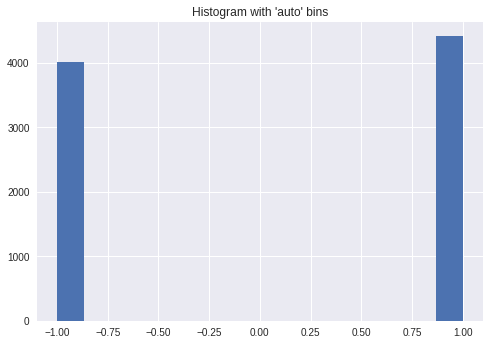

In [0]:
>>> plt.hist(full_df_sl['change_ind'], bins='auto')  # arguments are passed to np.histogram
>>> plt.title("Histogram with 'auto' bins")
>>> plt.show()

In [0]:
# Convert pd.df to np
full_df_sl = full_df_sl.values


TIMESTEPS = 60 # length of Sequence we use for our samples (7 = week, 30 = month) LAGS = 7
FEATURES = 1
INPUT_VARS = int(TIMESTEPS*FEATURES) # Every feature has as many columns as defined timestep

# INIT_T = 30000
# TEST_T = 10000

# INIT_T = 1000
# TEST_T = 400

INIT_T = 3000
TEST_T = 1200

# train = full_df[:INIT_T, :]
# test = full_df[INIT_T:(INIT_T+TEST_T), :]

train = full_df_sl[:INIT_T, :]
test = full_df_sl[INIT_T:(INIT_T+TEST_T), :]




X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]

y_train_diff = train[:, -2:-1]
y_test_diff = test[:, -2: -1]

# X_train = X_train/MAX_ABS
# X_test = X_test/MAX_ABS


#y_train = y_train/MAX_ABS
#y_test = y_test/MAX_ABS


# y_train.astype(int)
# y_test.astype(int)

(array([  1.,   2.,   6.,  23., 160., 596., 169.,  33.,   7.,   3.]),
 array([-16672.53354867, -13620.17090643, -10567.8082642 ,  -7515.44562197,
         -4463.08297973,  -1410.7203375 ,   1641.64230473,   4694.00494697,
          7746.3675892 ,  10798.73023143,  13851.09287367]),
 <a list of 10 Patch objects>)

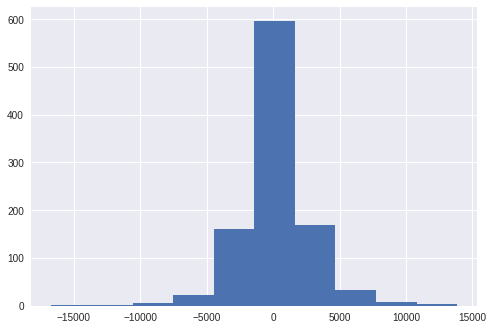

In [0]:
plt.hist(y_train_diff)

In [0]:
from sklearn.preprocessing import MinMaxScaler


# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
#dataset = scaler.fit_transform(X_train)
scaler.fit(X_train_pre)
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)



In [0]:

X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)

In [0]:
# 3 layers stacked LSTM SL

def build_model_stacked_sl(timesteps, n_neurons=6, batch_size=10, loss = 'binary_crossentropy', features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features), stateful=True, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=True, return_sequences=True))
    model.add(CuDNNLSTM(n_neurons, stateful=True))
    #model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(1, activation='tanh'))
    #model.compile(loss=loss, optimizer='adam')
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
def build_model_sl(timesteps, n_neurons=6, batch_size=10, loss = 'binary_crossentropy', features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    model.add(CuDNNLSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                       ))
    #model.add(Dense(1, activation='sigmoid'))
    model.add(Dense(1, activation='tanh'))
    
    #model.compile(loss=loss, optimizer='adam') 
    #model.compile(loss=loss, optimizer='RMSprop')
    
    #RMSprop = keras.optimizers.RMSprop(lr=0.1, rho=0.9, epsilon=None, decay=0.0)
    #model.compile(loss=loss, optimizer=RMSprop)
    
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)
    
    
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)

In [0]:
def tanh_cross_entropy(y_true, y_pred):
    epsilon = 1.0e-9
    y = y_true
    a = K.clip(y_pred, -1.0 + epsilon, 1.0 - epsilon)
    return K.mean(-.5 * ((1.0 - y) * K.log(1.0 - a) + (1.0 + y) * K.log(1.0 + a)) + np.log(2),
                  axis=-1)

## 1st iteration LSTM SL

20181231-134229


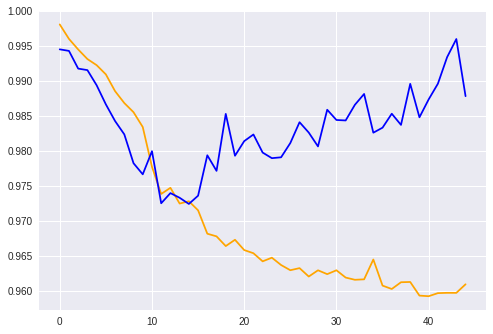

0.0005
10
30


In [0]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

BATCH_SIZE = 10
N_NEURONS = 30
LR = 0.0005
REPEATS = 1


#clr_triangular  = CyclicLR(mode='triangular')
#clr_triangular  = CyclicLR(mode='triangular2')
#clr_triangular._reset(new_base_lr=0.0001, new_max_lr=0.0005)

# clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.0005,
#                            step_size=20, mode='exp_range',
#                            gamma=0.99998)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00000000001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)


filepath_sl = timestr + "_" +"lstm_sl_weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_sl, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


filepath_loss_sl = timestr + "_" +"lstm_sl_weights.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_sl, monitor='loss', verbose=1, save_best_only=True, mode='min')


#plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, timestr = timestr#, what = 'acc', what2 = 'val_acc'
                        )


for i in range(REPEATS):
  print (i+1)
 
  model = build_model_sl(TIMESTEPS, batch_size = BATCH_SIZE, loss = 'mean_squared_error', #loss = tanh_cross_entropy, #'binary_crossentropy',
                      n_neurons = N_NEURONS, lr = LR)
  
#   model = build_model_stacked_sl(TIMESTEPS, batch_size = BATCH_SIZE, loss = 'mean_squared_error', #loss = tanh_cross_entropy, #'binary_crossentropy',
#                       n_neurons = N_NEURONS, lr = LR)
  
  
  
  model.fit(X_train, y_train,
            epochs= 100,
            batch_size=BATCH_SIZE,
            shuffle=True,
            validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[checkpoint, checkpoint_loss,  plot_losses, early_stop#, clr_triangular#
                       , reduce_lr
                      ],
            verbose=1)
  #model.reset_states()
    
    

## Save results of the 1st SL iteration 




In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload



folder_id = '1OY5DWOBOacbAin0xo9Y5QCDZyBUpDaTp'

file_metadata = {
    'name': filepath_sl,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filepath_sl,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))



#folder_id = '1g4LqMZICUFH5Vn-wbn-fKadIFg4OTHFN'

file_metadata = {
    'name': filepath_loss_sl,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filepath_loss_sl,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))





#folder_id = '1g4LqMZICUFH5Vn-wbn-fKadIFg4OTHFN'
comment = ""
filename_plot = timestr + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))

File ID: 1JXWmrCPBQLxzBBwm-xx59ONN_fbpmr9k
File ID: 11MjdKjksYr6YDUD6X3e4vslfvqOfprEG
File ID: 1y7vOZRaMNzIkRwVwrYLTq-dzLIskrd0C


In [0]:
losses = plot_losses.df_full

In [0]:
losses.columns

Index(['X', 'loss', 'val_loss'], dtype='object')

In [0]:
losses.loc[losses['val_loss'].idxmin()]

X           47.000000
loss         0.237025
val_loss     0.472919
Name: 47, dtype: float64

In [0]:
losses['loss'][losses['val_loss'].idxmin()]

0.2370246659964323

In [0]:
losses['val_loss'].min()

0.47291935235261917

In [0]:
# OPTIONAL - only if weights saved to a file

# BATCH_SIZE = 200
# N_NEURONS = 60
# LR = 0.0003

# REPEATS = 1


n_neurons=N_NEURONS
batch_size=BATCH_SIZE
features=1
timesteps = TIMESTEPS
lr = LR
#loss = 'binary_crossentropy'
loss = 'mean_squared_error'


model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath_sl)
#model.load_weights(filepath_loss_sl)

model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

In [0]:
model.evaluate(X_train[:800], y_train[:800], batch_size=BATCH_SIZE)

800/800 [==============================] - 5s 6ms/step


[0.9579907514154911, 0.00875000013038516]

In [0]:
yhat_train = model.predict(X_train, batch_size = BATCH_SIZE)

In [0]:
yhat_test = model.predict(X_test, batch_size = BATCH_SIZE)

In [0]:
plt.plot(yhat_train)
plt.show()

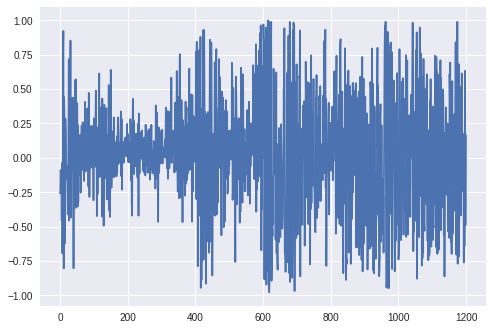

In [0]:
plt.plot(yhat_test)
plt.show()

## Actions from result

In [0]:
#yhat_test_df = np.column_stack((y_test, yhat_test))

# Use not-rescaled (original) data instead
#yhat_test_df = np.column_stack((y_test_pre, yhat_test))
yhat_test_df = np.column_stack((y_test_diff, yhat_test))

In [0]:
y_test_diff

array([[ -6868.468838  ],
       [ -2911.851654  ],
       [ -4190.89050017],
       ...,
       [-15862.43480833],
       [  -687.27283667],
       [  7854.51208   ]])

In [0]:
yhat_test_df

In [0]:
y_test.shape

(400,)

In [0]:
yhat_test.shape

(400, 1)

In [0]:
def action_from_results_df_sl(yhat_test_pre, THRESHOLD = 0.33): # read yhat as numpy array, return as DF with columns: result, action
    pd.options.mode.chained_assignment = None
    yhat_test_pre = pd.DataFrame(yhat_test_pre, columns=['price', 'result'])
    yhat_test_pre['action'] = 1
    yhat_test_pre['action'][(yhat_test_pre.result < -THRESHOLD)] = -1
    yhat_test_pre['action'][(yhat_test_pre.result > -THRESHOLD) & (yhat_test_pre.result < THRESHOLD)] = 0
    return yhat_test_pre



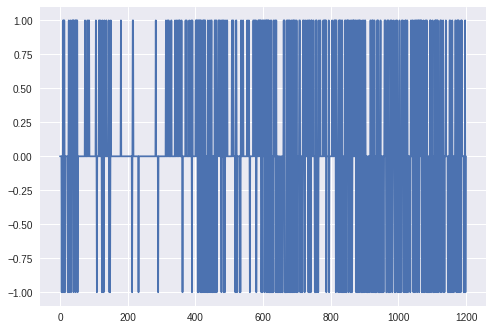

In [0]:
yhat_test_sl_1 = action_from_results_df_sl(yhat_test_df, THRESHOLD = 0.33)

plt.plot(yhat_test_sl_1['action'])
plt.show()

In [0]:
 # read yhat as DF with result and action, return as DF with added columns:price, action_diff, profit,cum_profit
def profit_from_result_df_sl(yhat_pre, fee = FEE, transaction_size = 300000):    

    yhat_pre['action_diff'] = yhat_pre['action'].diff().abs()

    # We start from 0
    yhat_pre['action_diff'][0] = yhat_pre['action'][0]

    # Don't use MAX_ABS, becase here min_max scaling is applied
    #yhat_pre['profit'] = yhat_pre['price']*yhat_pre['action'] - yhat_pre['action_diff'].abs()*fee*transaction_size
    #yhat_pre['profit_cum'] = yhat_pre['profit'].cumsum()
    
    yhat_pre['profit_rescale'] = yhat_pre['price']*yhat_pre['action'] \
                                - yhat_pre['action_diff'].abs()*fee*transaction_size
    yhat_pre['profit_cum_rescale'] = yhat_pre['profit_rescale'].cumsum()
    
    yhat_pre['profit_rescale_1k'] = (yhat_pre['price']*yhat_pre['action'] \
                                - yhat_pre['action_diff'].abs()*fee*transaction_size)/1000
    yhat_pre['profit_cum_rescale_1k'] = (yhat_pre['profit_rescale'].cumsum())/1000
    return yhat_pre


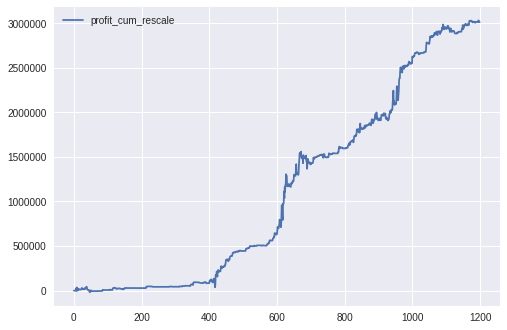

In [0]:
yhat_test_sl_2 = profit_from_result_df_sl(yhat_test_sl_1)

plt.plot(yhat_test_sl_2['profit_cum_rescale'], label = 'profit_cum_rescale')
plt.legend()
plt.show()

In [0]:
type(yhat_test_sl_2)


pandas.core.frame.DataFrame

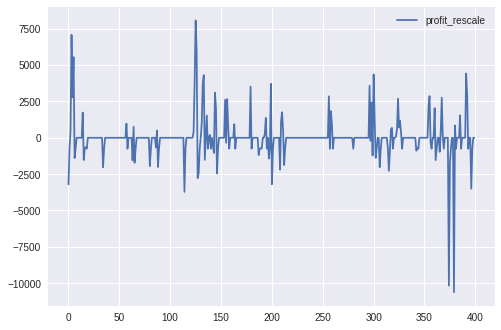

In [0]:
plt.plot(yhat_test_sl_2['profit_rescale'], label = 'profit_rescale')
plt.legend()
plt.show()

In [0]:
#Download weights (on val_loss) from Drive
#2. Get the file
downloaded = drive.CreateFile({'id':'1lNYg-CFDUm8xvhv5o5e49AfV8_LT-dLY'}) # replace the id with id of file you want to access
downloaded.GetContentFile('20180910-102450_lstm_sl_weights.best.hdf5') 

#Assign filepath
filepath = '20180910-102450_lstm_sl_weights.best.hdf5'

In [0]:
# OPTIONAL - only if weights saved to a file

# BATCH_SIZE = 200
# N_NEURONS = 60
# LR = 0.0003

# REPEATS = 1


n_neurons=N_NEURONS
batch_size=BATCH_SIZE
features=1
timesteps = TIMESTEPS
lr = LR
#loss = 'binary_crossentropy'
loss = 'mean_squared_error'


model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath_sl)
#model.load_weights(filepath_loss_sl)

model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

In [0]:
# from google.colab import files
# files.download('weights.best.hdf5')
# files.download('weights.best_loss.hdf5')

In [0]:
yhat_train = model.predict(X_train, batch_size = BATCH_SIZE)

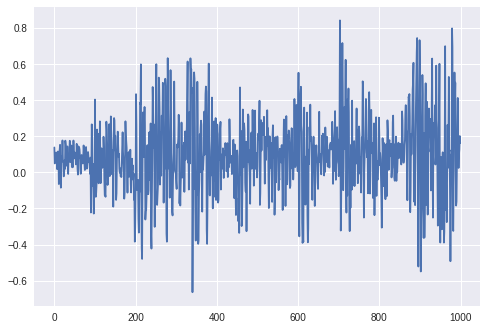

In [0]:
yhat_test = model.predict(X_test, batch_size = BATCH_SIZE)
plt.plot(yhat_train)
plt.show()

## SL LSTM manual iterations

20190101-155926_iter_4_


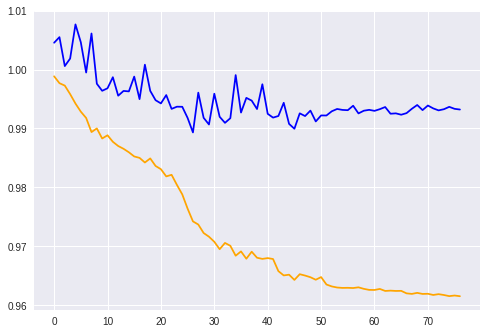

0.000125
10
30


In [0]:
INIT_T = 3000
TEST_T = 1200


BATCH_SIZE = 10
N_NEURONS = 30
LR = 0.0005


N_EPOCHS = 200
TIMESTEPS = 60
REPEATS = 1


# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE

#loss = 'mean_squared_error'
loss = 'squared_hinge'
#loss = 'hinge'

features=1
timesteps = TIMESTEPS
lr = LR


yhat_test = np.empty((0,2), float)

#### ITERATION !!!! 0 to 4
t = 4


train = full_df_sl[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df_sl[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]

y_train_diff = train[:, -2:-1]
y_test_diff = test[:, -2: -1]


# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
#dataset = scaler.fit_transform(X_train)
scaler.fit(X_train_pre)
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)



X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)



#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)

##### import time
timestr_f = time.strftime("%Y%m%d-%H%M%S")    

filepath_f_sl = timestr_f + "_" + "weights_f_sl.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_f_sl, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

filepath_loss_f_sl = timestr_f + "_" + "weights_f_sl.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f_sl, monitor='loss', verbose=1, save_best_only=True, mode='min')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='min')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)


#     clr_triangular  = CyclicLR(base_lr=0.00001, max_lr=0.0006,
#                            step_size=100., mode='exp_range',
#                            gamma=0.99998)


plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)

print(t)
print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df_sl)))

#     ####### BUILD MODEL TO RESET WEIGHTS
#     model = Sequential()
#     model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
#                        ))
#     model.add(Dense(1, activation='tanh'))
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
#     ####### end_of: BUILD MODEL TO RESET WEIGHTS



model = build_model_sl(TIMESTEPS, batch_size = BATCH_SIZE, loss = loss, #loss = tanh_cross_entropy, #'binary_crossentropy',
                  n_neurons = N_NEURONS, lr = LR)

    

#model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
model.fit(X_train, y_train,
      epochs=N_EPOCHS,
      batch_size=BATCH_SIZE,
      shuffle=True,
      validation_split=0.2, # if training 15k then split into 12k train 3k validation
      callbacks=[#early_stop, 
                 checkpoint, checkpoint_loss,  plot_losses, early_stop#, clr_triangular#
                   , reduce_lr],
      verbose=1)


#model.load_weights("weights_f.best.hdf5")
model.load_weights(filepath_f_sl)
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=adam)


#     yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
#     yhat_test = np.append(yhat_test, yhat_test_temp)
pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test_temp = np.column_stack((y_test_diff, pred_temp))
yhat_test = np.concatenate((yhat_test, yhat_test_temp))




In [0]:

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload


##### SAVING #######
# FOLDER_ID !!!
folder_id = '1Aas_jqShq69Egn7AamdRCF8FsLUUXJ3v'

##### Save plot to Drive
#folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test, delimiter=",")

#folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


File ID: 1NR9jDGI7XRnpxOpYFVVs3Pa8T2aATSVw
File ID: 15FxEPcWJt_gOWSBCYA9f_k2r6eWl7tqk


## SL LSTM wih iterations

In [0]:
# filepath_sl = "20180910-102450_weights.best.hdf5"
# filepath_loss_sl = "20180910-102450_weights.best_loss.hdf5"


from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload



20181231-160430_iter_4_


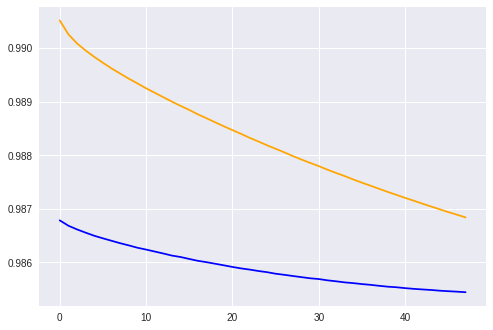

2.4414064e-07
10
30
Epoch 49/100
 900/2400 [==========>...................] - ETA: 18s - loss: 0.9799Buffered data was truncated after reaching the output size limit.

In [0]:
INIT_T = 3000
TEST_T = 1200


# BATCH_SIZE = 50
# N_NEURONS = 20

# LR = 0.001

# BATCH_SIZE = 600
# N_NEURONS = 60
# LR = 0.0005

BATCH_SIZE = 10
N_NEURONS = 30
LR = 0.0005


N_EPOCHS = 100

TIMESTEPS = 60
REPEATS = 1


# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = 'mean_squared_error'
features=1
timesteps = TIMESTEPS
lr = LR



##### BUILD MODEL with saved weights

# model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
# model.reset_states()

model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
                   ))
model.add(Dense(1, activation='tanh'))

#model.compile(loss=loss, optimizer='adam')
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath_sl)
model.compile(loss=loss, optimizer=adam)
######


#####  Don't train the model for the first round (use from saved weights from above)
t = 0
yhat_test = np.empty((0,2), float)


#### Rebuild the original test/train set
train = full_df_sl[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df_sl[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]




# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
#dataset = scaler.fit_transform(X_train)
scaler.fit(X_train_pre)
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)


# Rescale with MinMax scaler instead 
# X_train = X_train/MAX_ABS
# y_train = y_train/MAX_ABS
# X_test = X_test/MAX_ABS
# y_test = y_test/MAX_ABS


X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)



####### model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
# yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
# yhat_test = np.append(yhat_test, yhat_test_temp)
pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test_temp = np.column_stack((y_test, pred_temp))
yhat_test = np.concatenate((yhat_test, yhat_test_temp))


t += 1


###### Loop for further iterations
while ((INIT_T + TEST_T*t) <= len(full_df_sl)):

    train = full_df_sl[(TEST_T*t) : (INIT_T + TEST_T*t), :]
    test = full_df_sl[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

    X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
    X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]
    
    y_train_diff = train[:, -2:-1]
    y_test_diff = test[:, -2: -1]
    
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #dataset = scaler.fit_transform(X_train)
    scaler.fit(X_train_pre)
    X_train = scaler.transform(X_train_pre)
    X_test = scaler.transform(X_test_pre)


    

    X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
    X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)

#     # Rescale
#     X_train = X_train/MAX_ABS
#     y_train = y_train/MAX_ABS
#     X_test = X_test/MAX_ABS
#     y_test = y_test/MAX_ABS

    
    #reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)

##### import time
    timestr_f = time.strftime("%Y%m%d-%H%M%S")    
    
    filepath_f_sl = timestr_f + "_" + "weights_f_sl.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath_f_sl, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    filepath_loss_f_sl = timestr_f + "_" + "weights_f_sl.best_loss.hdf5"
    checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f_sl, monitor='loss', verbose=1, save_best_only=True, mode='min')
    
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)


#     clr_triangular  = CyclicLR(base_lr=0.00001, max_lr=0.0006,
#                            step_size=100., mode='exp_range',
#                            gamma=0.99998)
    
    #plot_losses = PlotLosses(REPEATS)
    plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)
    
    print(t)
    print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df_sl)))

#     ####### BUILD MODEL TO RESET WEIGHTS
#     model = Sequential()
#     model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
#                        ))
#     model.add(Dense(1, activation='tanh'))
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
#     ####### end_of: BUILD MODEL TO RESET WEIGHTS

#     model = build_model_sl(TIMESTEPS, batch_size = BATCH_SIZE, loss = loss, #loss = tanh_cross_entropy, #'binary_crossentropy',
#                       n_neurons = N_NEURONS, lr = LR)
  
    
    
    #model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
    model.fit(X_train, y_train,
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=True,
          validation_split=0.2, # if training 15k then split into 12k train 3k validation
          callbacks=[#early_stop, 
                     checkpoint, checkpoint_loss,  plot_losses, early_stop#, clr_triangular#
                       , reduce_lr],
          verbose=1)

    
    #model.load_weights("weights_f.best.hdf5")
    model.load_weights(filepath_f_sl)
    model.compile(loss=loss, optimizer=adam)
    
  
#     yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
#     yhat_test = np.append(yhat_test, yhat_test_temp)
    pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
    yhat_test_temp = np.column_stack((y_test_diff, pred_temp))
    yhat_test = np.concatenate((yhat_test, yhat_test_temp))
    

##### SAVING #######
# FOLDER_ID !!!
    folder_id = '1OY5DWOBOacbAin0xo9Y5QCDZyBUpDaTp'
    
##### Save plot to Drive
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
    comment = ("_iter_" + str(t) + "_")
    filename_plot = timestr_f + comment + "_loss_plot.png"

    file_metadata = {
        'name': filename_plot,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                            mimetype='image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
    
    
##### Save predicition results to csv to Drive
    csvfile = (timestr_f + "_yhat_test.csv")
    np.savetxt(csvfile, yhat_test, delimiter=",")
    
    #folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

    file_metadata = {
        'name': csvfile,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                            mimetype='text/plain', #'image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
      
    
##### Increase t
    t += 1


In [0]:
csvfile

'20181231-160430_yhat_test.csv'

## Check the iternation results from csv

In [0]:
import os
print( os.getcwd() )
#print( os.listdir('data') )
print( os.listdir() )

/content
['.config', 'bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv', '20181226-203204_yhat_test.csv', 'adc.json', 'sample_data']


In [0]:
#### OPTIONAL

#2. Get the file
downloaded = drive.CreateFile({'id':'1hJFnO8f27llSHEgZquRxsujKWdFJHmFW'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded.GetContentFile('20181226-203204_yhat_test.csv')  

#3. Read file as panda dataframe
#import pandas as pd
yhat_test_csv_lstm_sl = pd.read_csv('20181226-203204_yhat_test.csv',header=None) 

yhat_test_csv_lstm_sl.shape


In [0]:
#### OPTIONAL

#2. Get the file
downloaded0 = drive.CreateFile({'id':'1_Q4oIPd26AwhjCZuGc_JwXdquAbzmnhN'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded0.GetContentFile('20190101-150832_yhat_test.csv')  

downloaded1 = drive.CreateFile({'id':'1EibOxjjJJmLOgm7WZCPepIMMRxKC9r55'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded1.GetContentFile('20190101-151601_yhat_test.csv')  


downloaded2 = drive.CreateFile({'id':'1c_GY2jNLaB4axWUphtnUilynz1_5GUbk'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded2.GetContentFile('20190101-152110_yhat_test.csv')  


downloaded3 = drive.CreateFile({'id':'1naygTLVoM6lCd_L8Ty5WFX1J8jTKsflP'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded3.GetContentFile('20190101-155105_yhat_test.csv')

downloaded4 = drive.CreateFile({'id':'15FxEPcWJt_gOWSBCYA9f_k2r6eWl7tqk'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded4.GetContentFile('20190101-155926_yhat_test.csv')  


#3. Read file as panda dataframe
#import pandas as pd
yhat_test_csv_lstm_sl_0 = pd.read_csv('20190101-150832_yhat_test.csv',header=None) 
yhat_test_csv_lstm_sl_1 = pd.read_csv('20190101-151601_yhat_test.csv',header=None) 
yhat_test_csv_lstm_sl_2 = pd.read_csv('20190101-152110_yhat_test.csv',header=None) 
yhat_test_csv_lstm_sl_3 = pd.read_csv('20190101-155105_yhat_test.csv',header=None) 
yhat_test_csv_lstm_sl_4 = pd.read_csv('20190101-155926_yhat_test.csv',header=None) 


yhat_test_csv_lstm_sl_0.shape


(1200, 2)

In [0]:
type(yhat_test_csv_lstm_sl_0)

pandas.core.frame.DataFrame

In [0]:
yhat_test_csv_lstm_sl = yhat_test_csv_lstm_sl_0.append([yhat_test_csv_lstm_sl_1, yhat_test_csv_lstm_sl_2, yhat_test_csv_lstm_sl_3, yhat_test_csv_lstm_sl_4])
yhat_test_csv_lstm_sl

In [0]:
yhat_test_0 = pd.DataFrame(yhat_test_0)
yhat_test_1 = pd.DataFrame(yhat_test_1)
yhat_test_2 = pd.DataFrame(yhat_test_2)
yhat_test_3 = pd.DataFrame(yhat_test_3)
yhat_test_4 = pd.DataFrame(yhat_test_4)

In [0]:
### check RNN results

yhat_test_rnn_sl = yhat_test_0.append([yhat_test_1, yhat_test_2, yhat_test_3, yhat_test_4])
yhat_test_rnn_sl.shape

(5430, 2)

In [0]:

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload


##### SAVING #######
# FOLDER_ID !!!
folder_id = '1oCjpB8zayMdS0Fb4CegkYUqowAoIs6BC'


##### Save predicition results to csv to Drive
csvfile = "20190101-yhat_test_rnn_sl_FULL.csv"
np.savetxt(csvfile, yhat_test_rnn_sl, delimiter=",")

file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


File ID: 1wm-TUeevT_XiOfaDdrp8DUsTmA-P4w3c


In [0]:
# locals()
# globals()

In [0]:
yhat_test_csv_lstm_sl.shape

(7200, 2)

In [0]:
#yhat_test_csv_lstm_sl[1]

In [0]:
full_df_sl.shape[0] - INIT_T

7430

In [0]:
# No prediction for the last 230 obs.... Adjust the loop
full_df_sl[INIT_T:(INIT_T + 18*TEST_T), :].shape

(7200, 62)

In [0]:
type(full_df_sl[INIT_T:(INIT_T + 18*TEST_T), -2: -1])

numpy.ndarray

In [0]:
type(yhat_test_csv_lstm_sl[1])

pandas.core.series.Series

In [0]:
yhat_test_csv_lstm_sl = pd.DataFrame(yhat_test)

In [0]:
yhat_lstm_sl_check = yhat_test_rnn_sl

In [0]:
yhat_lstm_sl_check = np.column_stack((pd.DataFrame(full_df_sl[INIT_T:(INIT_T + 18*TEST_T), -2: -1]), yhat_test_csv_lstm_sl[1]))

In [0]:
yhat_lstm_sl_check = np.column_stack((pd.DataFrame(full_df_sl[INIT_T:(INIT_T + 18*TEST_T), -2: -1]), yhat_lstm_sl_check[1]))

In [0]:
yhat_lstm_sl_check

array([[-6.86846884e+03, -3.17432404e-01],
       [-2.91185165e+03, -1.27983421e-01],
       [-4.19089050e+03,  6.21394515e-02],
       ...,
       [-3.33677981e+03,  1.65653005e-01],
       [-3.79785003e+03,  1.00865021e-01],
       [-5.10897002e+03, -1.94466040e-02]])

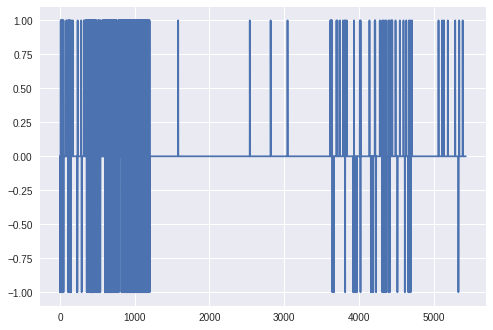

In [0]:
yhat_lstm_sl_check_1 = action_from_results_df_sl(yhat_lstm_sl_check, THRESHOLD = 0.33)

plt.plot(yhat_lstm_sl_check_1['action'])
plt.show()


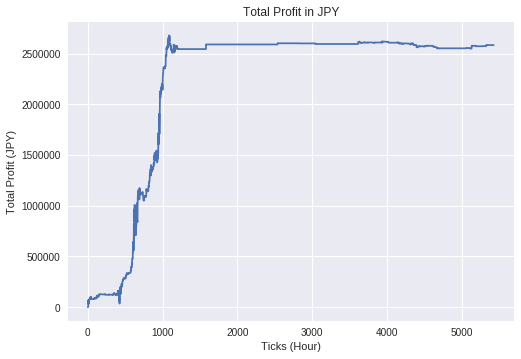

In [0]:
yhat_lstm_sl_check_2 = profit_from_result_df_sl(yhat_lstm_sl_check_1)

plt.plot(yhat_lstm_sl_check_2['profit_cum_rescale']) #, label = 'profit_cum_rescale')
plt.xlabel("Ticks (Hour)")
plt.ylabel("Total Profit (JPY)")
plt.title("Total Profit in JPY")
#plt.legend()
plt.show()

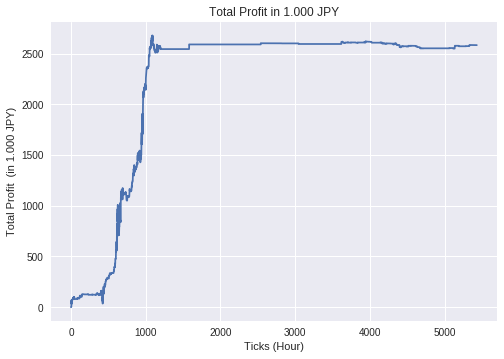

In [0]:
yhat_lstm_sl_check_2 = profit_from_result_df_sl(yhat_lstm_sl_check_1)

plt.plot(yhat_lstm_sl_check_2['profit_cum_rescale_1k']) #, label = 'profit_cum_rescale')
plt.xlabel("Ticks (Hour)")
plt.ylabel("Total Profit  (in 1.000 JPY)")
plt.title("Total Profit in 1.000 JPY")
#plt.legend()
plt.show()

#.....BUILD SL model - RNN

In [0]:
# Convert pd.df to np
full_df_sl = pd.DataFrame(full_df_sl).values


TIMESTEPS = 60 # length of Sequence we use for our samples (7 = week, 30 = month) LAGS = 7
FEATURES = 1
INPUT_VARS = int(TIMESTEPS*FEATURES) # Every feature has as many columns as defined timestep

# INIT_T = 30000
# TEST_T = 10000

INIT_T = 1000
TEST_T = 400

# train = full_df[:INIT_T, :]
# test = full_df[INIT_T:(INIT_T+TEST_T), :]

train = full_df_sl[:INIT_T, :]
test = full_df_sl[INIT_T:(INIT_T+TEST_T), :]




X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]

y_train_diff = train[:, -2:-1]
y_test_diff = test[:, -2: -1]





from sklearn.preprocessing import MinMaxScaler


# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
#dataset = scaler.fit_transform(X_train)
scaler.fit(X_train_pre)
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)



X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)



In [0]:
def build_model_rnn_sl(timesteps, n_neurons=6, batch_size=10, loss = 'binary_crossentropy', features=1, lr = 0.0001):
    #LSTM CELL
    #the shape of the input to an LSTMCell would be (batch_size, input_dim)
    model = Sequential()
    
    model.add(SimpleRNN(n_neurons, batch_input_shape=(batch_size, timesteps, features)))
    model.add(Dense(1, activation='tanh'))
     
    adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0001, amsgrad=False)
    model.compile(loss=loss, optimizer=adam)  
    
    return model

#model = build_model(TIMESTEPS, batch_size = BATCH_SIZE)


## 1st iteration  RNN SL

20181227-184437


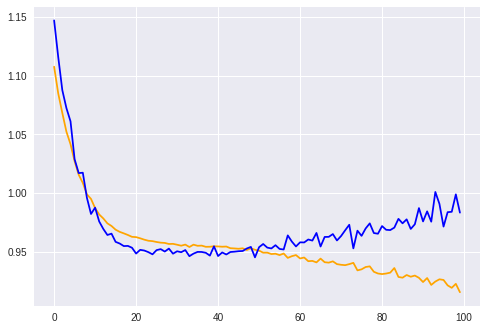

0.001
50
10


In [0]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")

BATCH_SIZE = 50
N_NEURONS = 10
LR = 0.001
REPEATS = 1


#clr_triangular  = CyclicLR(mode='triangular')
#clr_triangular  = CyclicLR(mode='triangular2')
#clr_triangular._reset(new_base_lr=0.0001, new_max_lr=0.0005)

clr_triangular  = CyclicLR(base_lr=0.00005, max_lr=0.0005,
                           step_size=20, mode='exp_range',
                           gamma=0.99998)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=0, mode='min')

#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00000000001)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=5, min_lr=0.00000000001)


filepath_sl = timestr + "_" +"rnn_sl_weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_sl, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


filepath_loss_sl = timestr + "_" +"rnn_sl_weights.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_sl, monitor='loss', verbose=1, save_best_only=True, mode='min')


#plot_losses = PlotLosses(REPEATS)
plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, timestr = timestr#, what = 'acc', what2 = 'val_acc'
                        )


for i in range(REPEATS):
  print (i+1)
  
  model = build_model_rnn_sl(TIMESTEPS, batch_size = BATCH_SIZE, loss = 'mean_squared_error', #loss = tanh_cross_entropy, #'binary_crossentropy',
                      n_neurons = N_NEURONS, lr = LR)
  
  
  
  model.fit(X_train, y_train,
            epochs= 100,
            batch_size=BATCH_SIZE,
            shuffle=True,
            validation_split=0.2, # if training 15k then split into 12k train 3k validation
            callbacks=[checkpoint, checkpoint_loss,  plot_losses#, clr_triangular#
                       #, reduce_lr
                      ],
            verbose=1)
  #model.reset_states()
    
    

## Save results of the 1st SL RNN iteration 

In [0]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload



folder_id = '1jWpNbhWoqTGwD_mNlFQM97xx0XY3ms3Y'

file_metadata = {
    'name': filepath_sl,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filepath_sl,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))



folder_id = '1jWpNbhWoqTGwD_mNlFQM97xx0XY3ms3Y'

file_metadata = {
    'name': filepath_loss_sl,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filepath_loss_sl,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))





folder_id = '1jWpNbhWoqTGwD_mNlFQM97xx0XY3ms3Y'
comment = ""
filename_plot = timestr + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()

print('File ID: {}'.format(file.get('id')))

File ID: 1lx2gkf-d3Bcf1NCU6Scy-sawMREDkIT7
File ID: 1yzfQ0u3Gly34dVqwSRI_EZxhmZwp1eOr
File ID: 1j-xda_Q3ebpPI2Da4RYmvSm2TSw0KBKf


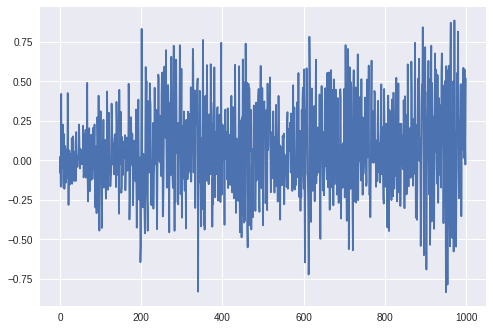

In [0]:
yhat_train = model.predict(X_train, batch_size = BATCH_SIZE)

yhat_test = model.predict(X_test, batch_size = BATCH_SIZE)


plt.plot(yhat_train)
plt.show()

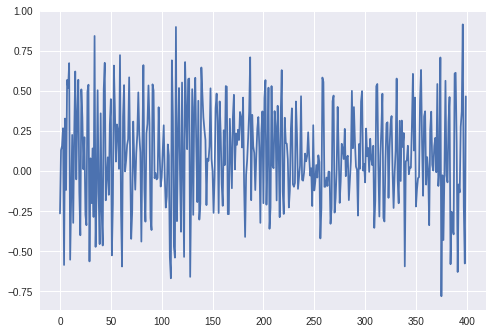

In [0]:
plt.plot(yhat_test)
plt.show()

In [0]:
yhat_test_df = np.column_stack((y_test_diff, yhat_test))

In [0]:

def action_from_results_df_sl(yhat_test_pre, THRESHOLD = 0.33): # read yhat as numpy array, return as DF with columns: result, action
    pd.options.mode.chained_assignment = None
    yhat_test_pre = pd.DataFrame(yhat_test_pre, columns=['price', 'result'])
    yhat_test_pre['action'] = 1
    yhat_test_pre['action'][(yhat_test_pre.result < -THRESHOLD)] = -1
    yhat_test_pre['action'][(yhat_test_pre.result > -THRESHOLD) & (yhat_test_pre.result < THRESHOLD)] = 0
    return yhat_test_pre

	
	 # read yhat as DF with result and action, return as DF with added columns:price, action_diff, profit,cum_profit
def profit_from_result_df_sl(yhat_pre, fee = FEE, transaction_size = 300000):    

    yhat_pre['action_diff'] = yhat_pre['action'].diff().abs()

    # We start from 0
    yhat_pre['action_diff'][0] = yhat_pre['action'][0]

    # Don't use MAX_ABS, becase here min_max scaling is applied
    #yhat_pre['profit'] = yhat_pre['price']*yhat_pre['action'] - yhat_pre['action_diff'].abs()*fee*transaction_size
    #yhat_pre['profit_cum'] = yhat_pre['profit'].cumsum()
    
    yhat_pre['profit_rescale'] = yhat_pre['price']*yhat_pre['action'] \
                                - yhat_pre['action_diff'].abs()*fee*transaction_size
    yhat_pre['profit_cum_rescale'] = yhat_pre['profit_rescale'].cumsum()
    return yhat_pre

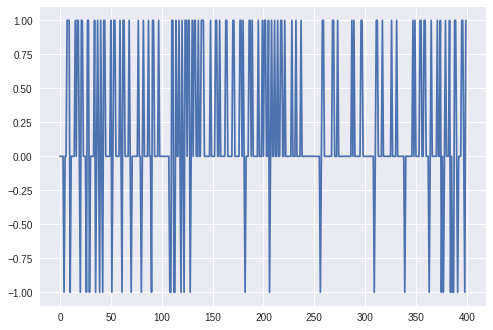

In [0]:
	
yhat_test_sl_1 = action_from_results_df_sl(yhat_test_df, THRESHOLD = 0.33)


plt.plot(yhat_test_sl_1['action'])
plt.show()

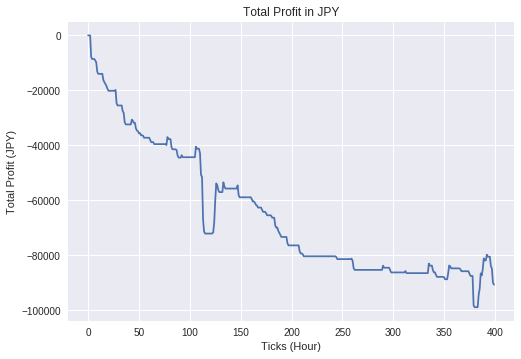

In [0]:

yhat_test_sl_2 = profit_from_result_df_sl(yhat_test_sl_2)

plt.plot(yhat_test_sl_2['profit_cum_rescale'])
plt.xlabel("Ticks (Hour)")
plt.ylabel("Total Profit (JPY)")
plt.title("Total Profit in JPY")
#plt.legend()
plt.show()

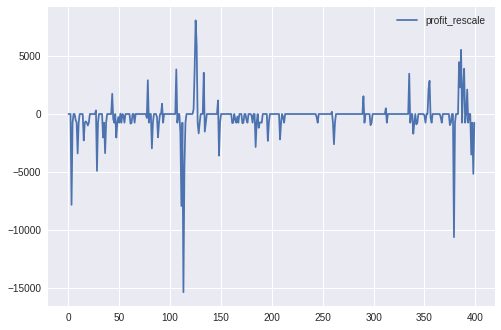

In [0]:

plt.plot(yhat_test_sl_2['profit_rescale'], label = 'profit_rescale')
plt.legend()
plt.show()

## SL RNN with manual iterations

20190101-213811_iter_4_


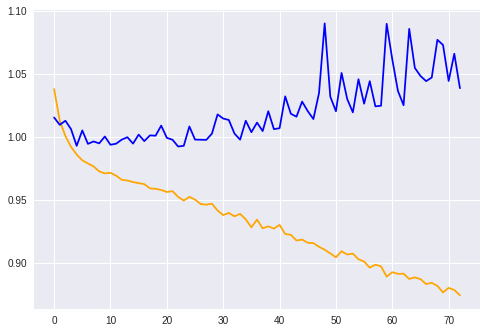

0.0005
10
30


In [0]:
INIT_T = 3000
TEST_T = 1200


BATCH_SIZE = 10
N_NEURONS = 30
LR = 0.0005


N_EPOCHS = 200
TIMESTEPS = 60
REPEATS = 1


# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE

#loss = 'mean_squared_error'
loss = 'squared_hinge'
#loss = 'hinge'

features=1
timesteps = TIMESTEPS
lr = LR


yhat_test = np.empty((0,2), float)

#### ITERATION !!!! 0 to 4
t = 4


train = full_df_sl[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df_sl[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]

y_train_diff = train[:, -2:-1]
y_test_diff = test[:, -2: -1]


# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
#dataset = scaler.fit_transform(X_train)
scaler.fit(X_train_pre)
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)



X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)



#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)

##### import time
timestr_f = time.strftime("%Y%m%d-%H%M%S")    

filepath_f_sl = timestr_f + "_" + "weights_f_sl.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_f_sl, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

filepath_loss_f_sl = timestr_f + "_" + "weights_f_sl.best_loss.hdf5"
checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f_sl, monitor='loss', verbose=1, save_best_only=True, mode='min')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=0, mode='min')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)


#     clr_triangular  = CyclicLR(base_lr=0.00001, max_lr=0.0006,
#                            step_size=100., mode='exp_range',
#                            gamma=0.99998)


plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)

print(t)
print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df_sl)))

#     ####### BUILD MODEL TO RESET WEIGHTS
#     model = Sequential()
#     model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
#                        ))
#     model.add(Dense(1, activation='tanh'))
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
#     ####### end_of: BUILD MODEL TO RESET WEIGHTS


model = build_model_rnn_sl(TIMESTEPS, batch_size = BATCH_SIZE, loss = loss, #loss = tanh_cross_entropy, #'binary_crossentropy',
                  n_neurons = N_NEURONS, lr = LR)

    

#model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
model.fit(X_train, y_train,
      epochs=N_EPOCHS,
      batch_size=BATCH_SIZE,
      shuffle=True,
      validation_split=0.2, # if training 15k then split into 12k train 3k validation
      callbacks=[#early_stop, 
                 checkpoint, checkpoint_loss,  plot_losses, early_stop#, clr_triangular#
                   , reduce_lr],
      verbose=1)


#model.load_weights("weights_f.best.hdf5")
model.load_weights(filepath_f_sl)
adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=adam)


#     yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
#     yhat_test = np.append(yhat_test, yhat_test_temp)
pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test = np.column_stack((y_test_diff, pred_temp))
#yhat_test_temp = np.column_stack((y_test_diff, pred_temp))
#yhat_test = np.concatenate((yhat_test, yhat_test_temp))




In [0]:
yhat_test_4 = yhat_test

In [0]:

from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload


##### SAVING #######
# FOLDER_ID !!!
folder_id = '1oCjpB8zayMdS0Fb4CegkYUqowAoIs6BC'

##### Save plot to Drive
#folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'
comment = ("_iter_" + str(t) + "_")
filename_plot = timestr_f + comment + "_loss_plot.png"

file_metadata = {
    'name': filename_plot,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                        mimetype='image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


##### Save predicition results to csv to Drive
csvfile = (timestr_f + "_yhat_test.csv")
np.savetxt(csvfile, yhat_test_4, delimiter=",")

#folder_id = '1NAKUyPeXw1orYKj7yT_O1oZyLsgC25On'

file_metadata = {
    'name': csvfile,   #filepath #filepath_loss
    'parents': [folder_id]
}
media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                        mimetype='text/plain', #'image/jpeg', #text/plain
                        resumable=True)
file = drive_service.files().create(body=file_metadata,
                                    media_body=media,
                                    fields='id').execute()
print('File ID: {}'.format(file.get('id')))


File ID: 1VX5PRuC-lRB6CJlWkvMqq8NdolcHvMPf
File ID: 1XNox_6LkxKkCWX3fkKvDxgGhTm1-8_Gz


## SL RNN with iterations

In [0]:
#filepath_sl = "20180910-102450_weights.best.hdf5"
# filepath_loss_sl = "20180910-102450_weights.best_loss.hdf5"


from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

from googleapiclient.http import MediaFileUpload


20181227-193328_iter_17_


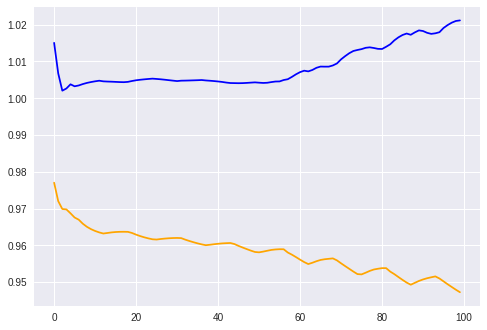

1e-05
50
10
File ID: 1nBCOqX3Wp0U-2djZraaYXDdPL6jhgvOO
File ID: 1GVkwhF_BlqeUNpT2ttWyAIOKonuE8WBA


In [0]:

BATCH_SIZE = 50
N_NEURONS = 10

TIMESTEPS = 60
N_EPOCHS = 100

LR = 0.001
REPEATS = 1


# Full predicition - NEW VERSION

n_neurons=N_NEURONS
batch_size=BATCH_SIZE
loss = 'mean_squared_error'
features=1
timesteps = TIMESTEPS
lr = LR



##### BUILD MODEL with saved weights

# model = build_model(TIMESTEPS, batch_size = BATCH_SIZE, loss = negative_profit, n_neurons = N_NEURONS)
# model.reset_states()

model = Sequential()
model.add(SimpleRNN(n_neurons, batch_input_shape=(batch_size, timesteps, features)))
model.add(Dense(1, activation='tanh'))

adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#model.load_weights("weights.best.hdf5")
model.load_weights(filepath_sl)
model.compile(loss=loss, optimizer=adam)
######


#####  Don't train the model for the first round (use from saved weights from above)
t = 0
yhat_test = np.empty((0,2), float)


#### Rebuild the original test/train set
train = full_df_sl[(TEST_T*t) : (INIT_T + TEST_T*t), :]
test = full_df_sl[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]




# normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
#dataset = scaler.fit_transform(X_train)
scaler.fit(X_train_pre)
X_train = scaler.transform(X_train_pre)
X_test = scaler.transform(X_test_pre)


# Rescale with MinMax scaler instead 
# X_train = X_train/MAX_ABS
# y_train = y_train/MAX_ABS
# X_test = X_test/MAX_ABS
# y_test = y_test/MAX_ABS


X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)



####### model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
# yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
# yhat_test = np.append(yhat_test, yhat_test_temp)
pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
yhat_test_temp = np.column_stack((y_test, pred_temp))
yhat_test = np.concatenate((yhat_test, yhat_test_temp))


t += 1


###### Loop for further iterations
while ((INIT_T + TEST_T*t + TEST_T) <= len(full_df_sl)):

    train = full_df_sl[(TEST_T*t) : (INIT_T + TEST_T*t), :]
    test = full_df_sl[(INIT_T + TEST_T*t) : (INIT_T + TEST_T*t + TEST_T), :]

    X_train_pre, y_train = train[:, :INPUT_VARS], train[:, -1]
    X_test_pre, y_test = test[:, :INPUT_VARS], test[:, -1]
    
    y_train_diff = train[:, -2:-1]
    y_test_diff = test[:, -2: -1]
    
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(-1, 1))
    #dataset = scaler.fit_transform(X_train)
    scaler.fit(X_train_pre)
    X_train = scaler.transform(X_train_pre)
    X_test = scaler.transform(X_test_pre)


    

    X_train = X_train.reshape(X_train.shape[0], TIMESTEPS, FEATURES)
    X_test = X_test.reshape(X_test.shape[0], TIMESTEPS, FEATURES)

#     # Rescale
#     X_train = X_train/MAX_ABS
#     y_train = y_train/MAX_ABS
#     X_test = X_test/MAX_ABS
#     y_test = y_test/MAX_ABS

    
    #reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.00000000001)

##### import time
    timestr_f = time.strftime("%Y%m%d-%H%M%S")    
    
    filepath_f_sl = timestr_f + "_" + "weights_f_sl_rnn.best.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath_f_sl, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    filepath_loss_f_sl = timestr_f + "_" + "weights_f_sl_rnn.best_loss.hdf5"
    checkpoint_loss = keras.callbacks.ModelCheckpoint(filepath_loss_f_sl, monitor='loss', verbose=1, save_best_only=True, mode='min')
    
    early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=100, verbose=0, mode='auto'#, baseline=None
                                              )

    clr_triangular  = CyclicLR(base_lr=0.00001, max_lr=0.0006,
                           step_size=100., mode='exp_range',
                           gamma=0.99998)
    
    #plot_losses = PlotLosses(REPEATS)
    plot_losses = PlotLosses(REPEATS, BATCH_SIZE, N_NEURONS, comment=("_iter_" + str(t) + "_"),  timestr = timestr_f)
    
    print(t)
    print(str(INIT_T + TEST_T*t + TEST_T) + "___of___" + str(len(full_df_sl)))

#     ####### BUILD MODEL TO RESET WEIGHTS
#     model = Sequential()
#     model.add(LSTM(n_neurons, batch_input_shape=(batch_size, timesteps, features)#, stateful=True
#                        ))
#     model.add(Dense(1, activation='tanh'))
#     adam = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#     model.compile(loss=loss, optimizer=adam)
#     ####### end_of: BUILD MODEL TO RESET WEIGHTS
    
    
    #model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size = BATCH_SIZE, verbose=1, shuffle=False)
    model.fit(X_train, y_train,
          epochs=N_EPOCHS,
          batch_size=BATCH_SIZE,
          shuffle=False,
          validation_split=0.2, # if training 15k then split into 12k train 3k validation
          callbacks=[#early_stop, 
                     checkpoint, checkpoint_loss,  plot_losses, clr_triangular#, reduce_lr
                    ],
          verbose=1)

    
    #model.load_weights("weights_f.best.hdf5")
    model.load_weights(filepath_f_sl)
    model.compile(loss=loss, optimizer=adam)
    
  
#     yhat_test_temp = model.predict(X_test, batch_size = BATCH_SIZE)
#     yhat_test = np.append(yhat_test, yhat_test_temp)
    pred_temp = model.predict(X_test, batch_size = BATCH_SIZE)
    yhat_test_temp = np.column_stack((y_test_diff, pred_temp))
    yhat_test = np.concatenate((yhat_test, yhat_test_temp))
    

##### SAVING #######
# FOLDER_ID !!!
    folder_id = '1jWpNbhWoqTGwD_mNlFQM97xx0XY3ms3Y'
    
##### Save plot to Drive

    comment = ("_iter_" + str(t) + "_")
    filename_plot = timestr_f + comment + "_loss_plot.png"

    file_metadata = {
        'name': filename_plot,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(filename_plot,   #filepath #filepath_loss
                            mimetype='image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
    
    
##### Save predicition results to csv to Drive
    csvfile = (timestr_f + "_yhat_test.csv")
    np.savetxt(csvfile, yhat_test, delimiter=",")
    

    file_metadata = {
        'name': csvfile,   #filepath #filepath_loss
        'parents': [folder_id]
    }
    media = MediaFileUpload(csvfile,   #filepath #filepath_loss
                            mimetype='text/plain', #'image/jpeg', #text/plain
                            resumable=True)
    file = drive_service.files().create(body=file_metadata,
                                        media_body=media,
                                        fields='id').execute()
    print('File ID: {}'.format(file.get('id')))
      
    
##### Increase t
    t += 1


In [0]:
#### OPTIONAL

#2. Get the file
downloaded = drive.CreateFile({'id':'1GVkwhF_BlqeUNpT2ttWyAIOKonuE8WBA'}) # replace the id with id of FILE you want to access (not folder-id)
downloaded.GetContentFile('20181227-193328_yhat_test.csv')  

#3. Read file as panda dataframe
#import pandas as pd
yhat_test_csv_rnn_sl = pd.read_csv('20181227-193328_yhat_test.csv',header=None) 

yhat_test_csv_rnn_sl.shape


In [0]:
yhat_test.shape

(7200, 2)

In [0]:
yhat_test_csv_rnn_sl = pd.DataFrame(yhat_test)

In [0]:
full_df_sl[INIT_T:(INIT_T + 18*TEST_T), -2: -1].shape

(7200, 1)

In [0]:
yhat_test_csv_rnn_sl[:,1].shape

(7200,)

In [0]:
yhat_rnn_sl_check = np.column_stack((pd.DataFrame(full_df_sl[INIT_T:(INIT_T + 18*TEST_T), -2: -1]), yhat_test_csv_rnn_sl[:,1]))


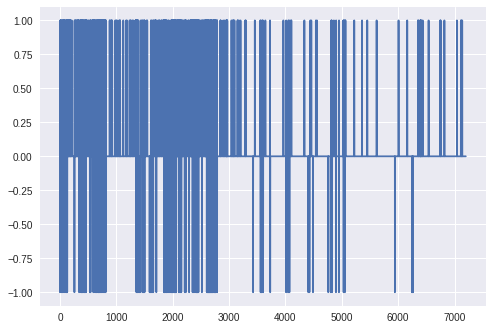

In [0]:
yhat_rnn_sl_check_1 = action_from_results_df_sl(yhat_rnn_sl_check, THRESHOLD = 0.33)

plt.plot(yhat_rnn_sl_check_1['action'])
plt.show()

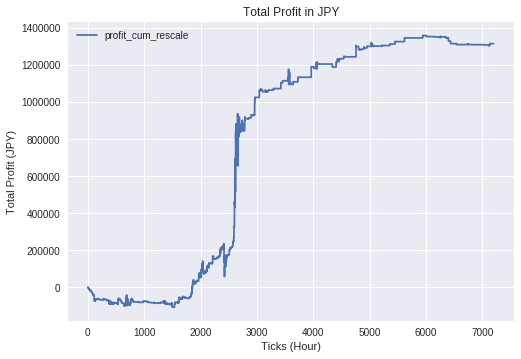

In [0]:
yhat_rnn_sl_check_2 = profit_from_result_df_sl(yhat_rnn_sl_check_1)

plt.plot(yhat_rnn_sl_check_2['profit_cum_rescale']) #, label = 'profit_cum_rescale')
plt.xlabel("Ticks (Hour)")
plt.ylabel("Total Profit (JPY)")
plt.title("Total Profit in JPY")
plt.legend()
plt.show()